In [1]:
# Pkg.add("JLD")
using JLD

In [2]:
# Pkg.add("Images")

In [3]:
using Images

GROUND_TRUTH_FOLDER = "/Users/manvithaponnapati/RAISR/train_data_new/ground_truth/"
LOW_RES_FOLDER = "/Users/manvithaponnapati/RAISR/train_data_new/low_res/"
INTERPOLATED_FOLDER = "/Users/manvithaponnapati/RAISR/train_data_new/interpolated/"

"/Users/manvithaponnapati/RAISR/train_data_new/interpolated/"

In [4]:
# Pkg.add("ImageMagick")

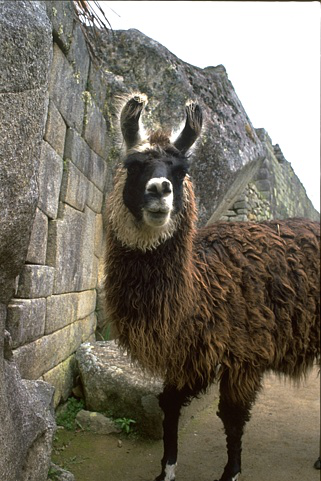

In [5]:
#High Resolution Image
high_res_im = load(GROUND_TRUTH_FOLDER*"6046.jpg")

In [6]:
w,h = size(high_res_im)
println("Image dimensions $w and $h")

Image dimensions 481 and 321


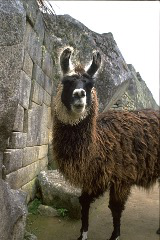

In [7]:
scale_factor = 2
scaled_dow_im = load(LOW_RES_FOLDER*"6046.jpg")
low_res_im = load(INTERPOLATED_FOLDER*"6046.jpg")
scaled_dow_im

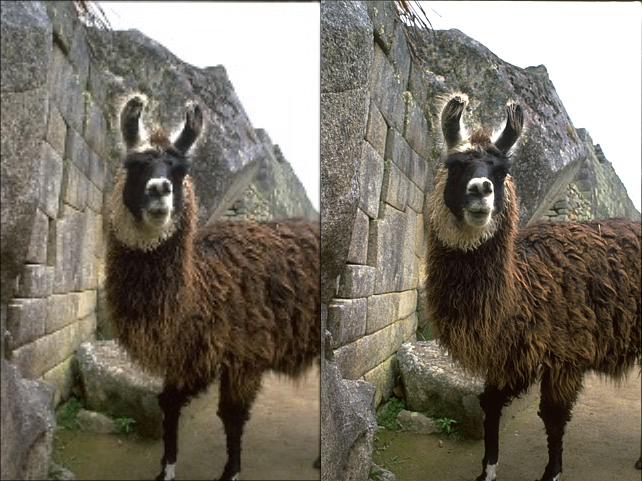

In [8]:
[low_res_im high_res_im]

In [9]:
# Pkg.add("Distributions")
function hashkey(patch,weights_matrix,patchsize)
    gx,gy = imgradients(patch,KernelFactors.ando3)
    gx = reshape(gx,patchsize*patchsize,1)
    gy = reshape(gy,patchsize*patchsize,1)
    GT = transpose([gx gy])
    GTWG = GT*weights_matrix*transpose(GT)
    eigen_max = eigmax(GTWG)
    eigen_min = eigmin(GTWG)
    eigen_vector_max = eigvecs(GTWG)[:,1]
    eigen_vector_min = eigvecs(GTWG)[:,2]
    gradient_angle = atan2(eigen_vector_max[2],eigen_vector_max[1])
    if gradient_angle < 0
        gradient_angle = gradient_angle + pi
    end
    lamda = abs(sqrt(complex(eigen_max)))/Qstrength
    u =(sqrt(complex(eigen_max)) -  sqrt(complex(eigen_min)))/(sqrt(complex(eigen_max)) +  sqrt(complex(eigen_min)))/Qcoherence
    angle = floor(gradient_angle/pi*Qangle)

    if lamda < 0.0001
        strength = 1
    elseif lamda > 0.001
        strength = 3
    else
        strength = 2
    end

    u = abs(u)
    if u < 0.25
        coherence = 1
    elseif u > 0.5
        coherence = 3
    else
        coherence = 2
    end


    # Bound the output to the desired ranges
    if angle > 23
        angle = 23
    elseif angle <= 0
        angle = 1
    end
    angle = Int(angle)
    
    return angle,strength,coherence
end

hashkey (generic function with 1 method)

In [10]:
using Distributions
#Calculate image properties
#Taking 3x3 patches on the imahes 
Qangle = 24
Qstrength = 3
Qcoherence = 3
patchsize = 11
gradientsize = 9
Q = zeros((Qangle, Qstrength, Qcoherence, scale_factor*scale_factor, patchsize*patchsize, patchsize*patchsize))
V = zeros((Qangle, Qstrength, Qcoherence, scale_factor*scale_factor, patchsize*patchsize))
mark = zeros((Qstrength*Qcoherence, Qangle, scale_factor*scale_factor))

start_index = Int(ceil(patchsize/2))
weights_matrix = rand(Normal(0, 2), gradientsize*gradientsize)
weights_matrix = Array(Diagonal(weights_matrix))
#the really really twosted conversions on JuliaImages
filenames = readdir(INTERPOLATED_FOLDER)
for file in filenames
    if (contains("$file", ".jpg")) == true
        println("File nm: $file")
        low_res_im = load(INTERPOLATED_FOLDER*file)
        ground_truth_im = load(GROUND_TRUTH_FOLDER*file)
        
        colorview_rgb = convert(Array{Float64},channelview(low_res_im))
        color_ve = 0.257*colorview_rgb[1,:,:]+ 0.504*colorview_rgb[2,:,:]+0.098*colorview_rgb[3,:,:]
        
        colorview_rgb_gt = convert(Array{Float64},channelview(ground_truth_im))
        color_ve_gt = 0.257*colorview_rgb[1,:,:]+ 0.504*colorview_rgb[2,:,:]+0.098*colorview_rgb[3,:,:]
        w,h = size(color_ve)
        @time for row in start_index:Int(w)-start_index
            for col in start_index:Int(h)-start_index
                
                patch = color_ve[row-5:row+5,col-5:col+5]
                gradientpatch = color_ve[row-4:row+4,col-4:col+4]
                
                angle,strength,coherence = hashkey(gradientpatch,weights_matrix,gradientsize)
#                 println("$angle,$strength,$coherence")
                # Get pixel type
                pixeltype = ((row-start_index) % scale_factor) * scale_factor + ((col-start_index) % scale_factor)
                pixelHR = color_ve_gt[row,col]
                # Compute A'A and A'b
                wp,hp = size(patch)
                patch_1 = reshape(patch,wp*hp,1)
                patch = reshape(patch,wp*hp)
                ATA = dot(transpose(patch_1),patch_1)
                ATb = patch*pixelHR
                Q[angle,strength,coherence,pixeltype+1,:,:] += ATA
                V[angle,strength,coherence,pixeltype+1,:] += ATb
                mark[coherence*3+strength, angle, pixeltype+1] += 1
            end
        end

    end
end



File nm: 2018.jpg
155.954307 seconds (54.33 M allocations: 40.233 GiB, 4.77% gc time)
File nm: 2092.jpg
101.496485 seconds (52.29 M allocations: 40.131 GiB, 5.83% gc time)
File nm: 3063.jpg
 95.363667 seconds (52.32 M allocations: 40.132 GiB, 5.95% gc time)
File nm: 5096.jpg
 99.196804 seconds (52.30 M allocations: 40.132 GiB, 6.56% gc time)
File nm: 6046.jpg
102.915118 seconds (52.27 M allocations: 40.131 GiB, 5.90% gc time)


In [11]:
Q

24×3×3×4×121×121 Array{Float64,6}:
[:, :, 1, 1, 1, 1] =
  0.0     22616.4        1.78254e5
  0.0      7077.39   61113.4      
  0.0      6317.84   52452.9      
  0.0      5674.41   47922.0      
  0.0      5873.55   43251.9      
  0.0      1461.86    9985.65     
  0.0      1337.41   11711.0      
  0.0       775.675  12246.4      
  0.0      1272.13   12872.7      
  0.0      1227.11   13952.2      
  0.0       957.741   9154.42     
  0.0       548.975   8311.29     
  0.0      1389.56   15526.2      
  0.0      1131.25   15265.3      
  0.0      2021.66   13227.9      
  0.0      1756.69   13136.4      
  0.0      1842.21   12261.8      
  0.0      6559.17   45512.4      
  0.0      8907.74   49145.5      
  0.0      9373.3    57425.1      
  0.0     11309.3    66062.3      
 89.2202  13603.5    81716.4      
 89.2704  15709.9    97064.4      
  0.0         0.0        0.0      

[:, :, 2, 1, 1, 1] =
     1.46972e5  56147.9       4.95588e5
   535.589      16733.5       1.58727e5
  

In [24]:
println("Preprocessing permutation matrices P for nearly-free 8x more learning examples ...")

P = zeros((patchsize*patchsize, patchsize*patchsize, 7))
rotate = zeros((patchsize*patchsize, patchsize*patchsize))
flip = zeros((patchsize*patchsize, patchsize*patchsize))

for i in range(1, patchsize*patchsize-2)
    i1 = i % patchsize
    i2 = Int(ceil(i / patchsize))
    j = (patchsize * patchsize - patchsize + i2 - patchsize * i1)+1 
    rotate[j,i] = 1
    k = patchsize * (i2 + 1) - i1 - 2
    println("$k $i1 $i2")
    flip[k,i] = 1
end

for i in range(1, 7)
    i1 = i % 4
    i2 = ceil(i / 4)
    P[:,:,i] = dot((flip^i2),(rotate^i1))
end
Qextended = zeros((Qangle, Qstrength, Qcoherence, scale_factor*scale_factor, patchsize*patchsize, patchsize*patchsize))
Vextended = zeros((Qangle, Qstrength, Qcoherence, scale_factor*scale_factor, patchsize*patchsize))

for pixeltype in range(1, scale_factor*scale_factor)
    for angle in range(1, Qangle)
        for strength in range(1, Qstrength)
            for coherence in range(1, Qcoherence)
                for m in range(1, 7)
                    m1 = m % 4
                    m2 = floor(m / 4)
                    newangleslot = angle
                    if m2 == 1
                        newangleslot = Qangle-angle-1
                    end
                    newangleslot = Int(newangleslot-Qangle/2*m1)
                    while newangleslot < 0
                        newangleslot += Qangle
                    end
                    
                    newQ = transpose(P[:,:,m])*(Q[angle,strength,coherence,pixeltype,:,:])*(P[:,:,m])
                    newV = transpose(P[:,:,m])*(V[angle,strength,coherence,pixeltype,:])
                    Qextended[newangleslot+1,strength,coherence,pixeltype,:,:] += newQ
                    Vextended[newangleslot+1,strength,coherence,pixeltype,:] += newV
                end
            end
        end
    end
end
Q += Qextended
V += Vextended

Preprocessing permutation matrices P for nearly-free 8x more learning examples ...
19 1 1
18 2 1
17 3 1
16 4 1
15 5 1
14 6 1
13 7 1
12 8 1
11 9 1
10 10 1
20 0 1
30 1 2
29 2 2
28 3 2
27 4 2
26 5 2
25 6 2
24 7 2
23 8 2
22 9 2
21 10 2
31 0 2
41 1 3
40 2 3
39 3 3
38 4 3
37 5 3
36 6 3
35 7 3
34 8 3
33 9 3
32 10 3
42 0 3
52 1 4
51 2 4
50 3 4
49 4 4
48 5 4
47 6 4
46 7 4
45 8 4
44 9 4
43 10 4
53 0 4
63 1 5
62 2 5
61 3 5
60 4 5
59 5 5
58 6 5
57 7 5
56 8 5
55 9 5
54 10 5
64 0 5
74 1 6
73 2 6
72 3 6
71 4 6
70 5 6
69 6 6
68 7 6
67 8 6
66 9 6
65 10 6
75 0 6
85 1 7
84 2 7
83 3 7
82 4 7
81 5 7
80 6 7
79 7 7
78 8 7
77 9 7
76 10 7
86 0 7
96 1 8
95 2 8
94 3 8
93 4 8
92 5 8
91 6 8
90 7 8
89 8 8
88 9 8
87 10 8
97 0 8
107 1 9
106 2 9
105 3 9
104 4 9
103 5 9
102 6 9
101 7 9
100 8 9
99 9 9
98 10 9
108 0 9
118 1 10
117 2 10
116 3 10
115 4 10
114 5 10
113 6 10
112 7 10
111 8 10
110 9 10
109 10 10
119 0 10
129 1 11


LoadError: [91mBoundsError: attempt to access 121×121 Array{Float64,2} at index [129, 111][39m

In [13]:
println("Calculating filterS")
# Conjugate Gradients Solver
function cgls(A, b)
   
    height, width = size(A)
    
    x = zeros((height))
    while(true)
        sumA = sum(A)
        
        if (sumA < 100)
            break
        end
        if (det(A) < 1)
            A = A + eye(height, width) * sumA * 0.000000005
        else
            x = inv(A)*b
            break
        end
    end
    println("Return $x")
    return x
end

h = zeros((Qangle, Qstrength, Qcoherence, scale_factor*scale_factor, patchsize*patchsize))
operationcount = 0
totaloperations = scale_factor * scale_factor * Qangle * Qstrength * Qcoherence
for pixeltype in range(1, scale_factor*scale_factor)
    for angle in range(1, Qangle)
        for strength in range(1, Qstrength)
            for coherence in range(1, Qcoherence)
                println(" K: index $pixeltype,$angle, $strength, $coherence")
                operationcount += 1
                h[angle,strength,coherence,pixeltype,:] = cgls(Q[angle,strength,coherence,pixeltype,:,:], V[angle,strength,coherence,pixeltype,:])
            end
        end
    end
end

Calculating filterS
 K: index 1,1, 1, 1
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 K: index 1,1, 1, 2
Return [-0.0124557, -0.00543469, -0.00407421, -0.00403794, -0.00404613, -0.00301087, -0.00137582, 0.000164736, 0.00123403, 0.0030691, -0.071858, -0.00106913, 0.00504897, 0.00696088, 0.00683275, 0.00720998, 0.00820648, 0.0107037, 0.0118496, 0.0133349, 0.015198, -0.0517715, -0.00147837, 0.00485504, 0.00639979, 0.00656925, 0.006

Return [-0.704921, -0.475914, -0.375509, -0.336632, -0.276974, -0.213462, -0.117355, -0.0371591, 0.0285847, 0.0904766, 0.16426, -0.507518, -0.253604, -0.168841, -0.1349, -0.0559688, 0.00114344, 0.109123, 0.186448, 0.248707, 0.30599, 0.373143, -0.463349, -0.241121, -0.156495, -0.1005, -0.0497274, 0.01217, 0.118781, 0.199332, 0.242564, 0.3288, 0.387889, -0.46093, -0.243648, -0.158421, -0.109735, -0.052367, 0.00515538, 0.139169, 0.197832, 0.253144, 0.331047, 0.395905, -0.474389, -0.254632, -0.152054, -0.115603, -0.0681404, 0.00434181, 0.128507, 0.18407, 0.241209, 0.299476, 0.382571, -0.476874, -0.253251, -0.164306, -0.115885, -0.0683899, -0.0021092, 0.136968, 0.196697, 0.26005, 0.314913, 0.392513, -0.48001, -0.251978, -0.163243, -0.122131, -0.0693068, 0.00610599, 0.129027, 0.184306, 0.25118, 0.302994, 0.383266, -0.459993, -0.253852, -0.144797, -0.105507, -0.057829, 0.0294469, 0.135578, 0.199072, 0.244362, 0.307715, 0.383932, -0.440472, -0.243951, -0.143616, -0.0775486, -0.0235785, 0.03991

Return [-0.00837519, -0.00685429, 0.00316571, 0.0002106, -0.00569962, -0.0116098, -0.00610025, 0.00687485, 0.00906626, 0.0110707, 0.00611758, -0.00837519, -0.00685429, 0.0002106, 0.0002106, -0.00112578, -0.007036, -0.00610025, 0.00584683, 0.00755159, 0.00870625, 0.00142331, -0.00837519, -0.00685429, -0.00274451, 0.0002106, -0.00112578, -0.00647969, -0.00550954, 0.00289172, 0.00459648, 0.00575114, 0.00142331, -0.00840959, -0.00688869, -0.00569962, -0.00274451, -0.000535067, -0.00352458, -0.00809842, -0.0064915, -0.00390262, -0.00341913, -0.0015027, -0.00688869, -0.00536779, -0.00865473, -0.007036, -0.00611346, -0.00611346, -0.00809842, -0.0165115, -0.0124017, -0.00600801, -0.00113647, -0.00429981, -0.00277891, -0.00606585, -0.00644529, -0.00352458, 0.00104926, -0.00809842, -0.0178479, -0.0124017, -0.00436018, 0.00178424, 0.000877945, 0.000877945, 0.00206701, 0.00168758, 0.00201941, 0.00659325, -0.00736381, -0.0148928, -0.00697815, 0.00155004, 0.0030055, 0.00288642, 0.00346682, 0.007611,

Return [-0.0275599, -0.0258391, -0.0250943, -0.0200108, -0.0206264, -0.0202888, -0.0148422, -0.0178012, -0.0168183, -0.0184905, -0.0160542, -0.0246009, -0.0258391, -0.0234957, -0.0200108, -0.0206264, -0.018283, -0.0124989, -0.0154578, -0.0115159, -0.0144749, -0.0122053, -0.0222056, -0.0205192, -0.0205192, -0.0154357, -0.010749, -0.00989812, -0.00644686, -0.00499347, -0.00270688, -0.00655115, -0.00428149, -0.0139442, -0.0152169, -0.0152169, -0.0101334, -0.00778997, -0.00459575, -0.00348788, -0.0011445, 0.000252099, -0.000363503, -0.000265865, -0.00864187, -0.00692108, -0.00695552, -0.001872, 0.000471378, 0.000471378, 0.00181449, 0.00341301, 0.00192434, 0.00259548, 0.0035784, -0.000996121, -0.00161871, -0.00161871, 0.00197697, 0.00343036, 0.00577374, 0.00392263, 0.00637199, 0.0072267, 0.00789785, 0.00711055, 0.00216866, 0.00227464, 0.00196286, 0.00072467, 0.00452145, 0.004487, 0.00621746, 0.00892118, 0.00886438, 0.00820963, 0.00816718, 0.00780861, 0.00410477, 0.00345541, 0.00602704, 0.00

Return [-0.00199991, -0.00199991, -0.00199991, -0.00199991, -0.000434966, -0.000434966, -0.000434966, 0.00112998, 0.0016911, 0.0016911, 0.0016911, -0.00199991, -0.00199991, -0.00199991, -0.00199991, -0.000434966, -0.000434966, -0.000434966, 0.00112998, 0.0016911, 0.0016911, 0.0016911, -0.00199991, -0.00199991, -0.00199991, -0.00199991, -0.000434966, -0.000434966, -0.000434966, 0.00112998, 0.0016911, 0.0016911, 0.0016911, -0.00199991, -0.00199991, -0.00199991, -0.00199991, -0.000434966, -0.000434966, -0.000434966, 0.00112998, 0.0016911, 0.0016911, 0.0016911, -0.00143879, -0.00143879, -0.00143879, -0.00143879, 0.000126156, 0.000126156, 0.0016911, 0.0016911, 0.0016911, 0.0016911, 0.0016911, -0.00143879, -0.00143879, -0.00143879, -0.00143879, 0.000126156, 0.000126156, 0.0016911, 0.0016911, 0.0016911, 0.0016911, 0.0016911, -0.00143879, -0.00143879, -0.00143879, -0.00143879, 0.000126156, 0.000126156, 0.0016911, 0.0016911, 0.0016911, 0.0016911, 0.0016911, -0.00143879, -0.00143879, -0.00143879

Return [0.00468637, 0.00468637, 0.00468637, 0.00397435, 0.00397435, 0.00397435, 0.00397435, 0.00102257, 0.00102257, 0.00173459, -0.00138594, 0.00468637, 0.00468637, 0.00468637, 0.00397435, 0.00397435, 0.00397435, 0.00102257, 0.00102257, 0.00102257, 0.00173459, -0.00138594, 0.00173459, 0.00173459, 0.00173459, 0.00102257, 0.00102257, 0.00102257, 0.00102257, 0.00102257, 0.000139442, 0.000851461, -0.00226907, 0.0022466, 0.0022466, 0.0022466, 0.00153458, 0.00153458, 0.00153458, 0.00153458, 0.00153458, 0.00153458, 0.0022466, -0.000873936, 0.0022466, 0.0022466, 0.0022466, 0.00153458, 0.00153458, 0.00153458, 0.00153458, 0.00153458, 0.00065145, 0.00136347, -0.00175707, 0.00136347, 0.00136347, 0.00136347, 0.00065145, 0.00065145, 0.00065145, 0.00065145, 0.00065145, 0.00065145, 0.00136347, -0.00175707, -0.00158831, -0.00158831, -0.00158831, -0.00158831, -0.00158831, -0.00158831, -0.00158831, -0.00158831, -0.000402788, -0.00162267, -0.00162267, -0.00162267, -0.00162267, -0.00162267, -0.00162267, -0

 K: index 1,8, 2, 1
Return [-0.0178133, -0.0202323, -0.0217652, -0.0192098, -0.0133594, -0.00574083, -0.0032912, -0.00241558, -0.00676726, -0.00128391, -0.00400517, -0.0222486, -0.01958, -0.0171019, -0.0220689, -0.0161558, -0.0139667, -0.00895338, -0.00770674, -0.0042905, -0.00514076, -0.00931807, -0.0198813, -0.0153833, -0.01173, -0.00990845, -0.0111022, -0.0123394, -0.00982299, -0.00911514, -0.00542449, -0.00312982, -0.0011033, -0.0178655, -0.013594, -0.0100359, -0.00487909, -0.00378851, -0.00265935, -0.00697538, -0.00448946, 0.00588581, 0.00920185, 0.0058146, -0.0147805, -0.00954432, -0.00742649, -0.00291771, -0.000620271, 0.0033193, 0.00575633, 0.0106505, 0.010226, 0.0117614, 0.0108625, -0.00591927, -0.0045781, -0.00520099, -0.00090153, 0.000179918, 0.0032728, 0.00891303, 0.0154456, 0.0171388, 0.013983, 0.0146615, -0.00995883, -0.0111094, -0.00544517, 0.000704552, 0.00353958, 0.00584132, 0.00785568, 0.0114302, 0.00606229, 0.00777637, 0.0142796, -0.00750814, -0.00718099, -0.00034621

Return [-0.00361003, -0.00212133, -0.00212133, -0.000632627, 0.000856074, 0.000856074, 0.00427887, 0.00427887, 0.00427887, 0.00130147, -0.00018723, -0.00361003, -0.00212133, -0.00212133, -0.000632627, 0.000856074, 0.000856074, 0.00427887, 0.00427887, 0.00427887, 0.00279017, -0.00018723, -0.00361003, -0.00212133, -0.00212133, -0.000632627, -0.000632627, -0.000632627, 0.00383347, 0.00383347, 0.00234477, 0.000856074, -0.00212133, -0.00361003, -0.00212133, -0.00212133, -0.000632627, -0.000632627, 0.000856074, 0.00234477, 0.00234477, 0.000856074, -0.000632627, -0.00212133, -0.00212133, -0.00212133, -0.000632627, -0.000632627, 0.000856074, 0.000856074, 0.00234477, 0.000856074, 0.000856074, -0.000632627, -0.00361003, -0.00212133, -0.00212133, -0.000632627, -0.000632627, 0.000856074, 0.000856074, 0.000856074, 0.000856074, -0.000632627, -0.00212133, -0.00361003, -0.00212133, -0.000632627, -0.000632627, 0.000856074, 0.000856074, 0.000856074, 0.000856074, 0.000856074, -0.000632627, -0.00212133, -

Return [0.000158643, 0.000158643, 0.000158643, 0.000158643, 0.000158643, 0.000158643, 0.000158643, 0.000158643, 0.00172919, 0.00172919, 0.00172919, 0.000158643, 0.000158643, 0.000158643, 0.000158643, 0.000158643, 0.000158643, 0.000158643, 0.000158643, 0.000158643, 0.00172919, 0.00172919, 0.000158643, 0.000158643, 0.000158643, 0.000158643, 0.000158643, 0.000158643, 0.000158643, 0.000158643, 0.000158643, 0.000158643, 0.00172919, 0.000158643, 0.000158643, 0.000158643, 0.000158643, -0.0014119, -0.0014119, -0.0014119, -0.0014119, 0.000158643, 0.000158643, 0.00172919, 0.000158643, 0.000158643, 0.000158643, 0.000158643, -0.0014119, -0.0014119, -0.0014119, -0.0014119, -0.0014119, 0.000158643, 0.000158643, 0.000158643, 0.000158643, 0.000158643, 0.000158643, -0.0014119, -0.0014119, -0.0014119, -0.0014119, 0.000158643, 0.000158643, 0.000158643, 0.000158643, 0.000158643, 0.000158643, 0.000158643, -0.0014119, -0.0014119, -0.0014119, -0.0014119, 0.000158643, 0.000158643, 0.00172919, 0.000158643, 0.0

 K: index 1,12, 1, 3
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 K: index 1,12, 2, 1
Return [-0.149807, -0.149876, -0.150736, -0.150451, -0.157284, -0.155353, -0.150219, -0.150219, -0.151108, -0.150457, -0.148996, 0.0156995, 0.0149889, 0.0160108, 0.018462, 0.0147531, 0.0157634, 0.0134696, 0.0151639, 0.015975, 0.0227664, 0.0195853, 0.0130884, 0.0145103, 0.0145103, 0.0159283, 0.0107831, 0.0137162, 0.0174229, 0.0174229, 0.0223567

Return [-3.78817, -3.64788, -3.44593, -3.25541, -2.62555, -2.01004, -1.98962, -1.97009, -2.25306, -2.48443, -2.89567, -2.71896, -2.47646, -2.34819, -2.22577, -1.53618, -0.938928, -1.17943, -1.41663, -1.83281, -2.21969, -2.65755, -2.19897, -1.74396, -1.37041, -1.0998, -0.346859, 0.256462, 0.0620937, -0.188005, -0.513417, -0.886608, -1.57862, -1.63711, -0.982421, -0.441409, 0.00918116, 0.802105, 1.50009, 1.24081, 0.950122, 0.713683, 0.4156, -0.462658, -1.48656, -0.822605, -0.130951, 0.519994, 1.88298, 3.15163, 2.75233, 2.32585, 1.96892, 1.5296, 0.360513, -1.33504, -0.652343, 0.217766, 1.03952, 2.93816, 4.69197, 4.18408, 3.63067, 3.1353, 2.54625, 1.20575, -1.62859, -1.03991, -0.277574, 0.492885, 2.01199, 3.42139, 3.28572, 3.11388, 2.50923, 1.89543, 0.673005, -1.89238, -1.38034, -0.699635, -0.0251582, 1.04877, 2.07306, 2.32444, 2.47884, 1.86593, 1.12403, 0.156116, -1.74657, -1.27794, -0.577738, 0.140165, 1.04708, 1.7866, 1.91492, 1.94833, 1.14397, 0.236501, -0.666796, -1.63872, -1.16213, -

Return [-1.87267, -1.76933, -2.01145, -2.3484, -2.26294, -2.24634, -2.18241, -1.98908, -2.06605, -2.12826, -2.48967, -1.1442, -0.823336, -1.13015, -1.48365, -1.57374, -1.63982, -1.63, -1.54005, -1.72483, -1.88142, -2.15588, -1.08307, -0.663784, -0.667281, -0.660178, -0.355584, -0.0680754, -0.235467, -0.4193, -0.76542, -1.04301, -1.43363, -1.08148, -0.559948, -0.174829, 0.158743, 0.854012, 1.50477, 1.13378, 0.73085, 0.220397, -0.167263, -0.705699, -0.823305, -0.269988, 0.134251, 0.498637, 1.65901, 2.81213, 2.38478, 1.93602, 1.41878, 0.933832, 0.175185, -0.586746, -0.0953755, 0.362374, 0.829054, 2.47313, 4.01599, 3.63576, 3.19464, 2.66143, 2.1343, 0.996066, -0.537497, -0.13836, 0.0718113, 0.322389, 1.37508, 2.39737, 2.38664, 2.358, 1.88666, 1.36313, 0.524406, -0.493176, -0.228906, -0.214173, -0.164686, 0.280454, 0.697009, 1.14562, 1.57712, 1.13873, 0.603836, 0.0614925, -0.640062, -0.437296, -0.229976, 0.0127197, 0.319318, 0.543736, 0.717405, 0.831202, 0.489132, 0.125554, -0.425559, -0.74

Return [-0.00212621, -0.000765319, 0.000777364, 0.000777364, 0.000482688, 0.00328963, 0.00328963, 0.0035843, 0.0035843, 0.00503034, 0.00639124, -0.00212621, -0.00212621, -0.000668678, 0.000777364, 0.000482688, 0.00192873, 0.00328963, 0.0035843, 0.0035843, 0.0035843, 0.00639124, -0.00357226, -0.00212621, -0.000668678, -0.000668678, 0.000482688, 0.000482688, 0.00184358, 0.0035843, 0.0035843, 0.0035843, 0.00639124, -0.00493315, -0.00357226, -0.00211472, -0.000668678, -0.000963354, 0.000482688, 0.00184358, 0.00213826, 0.0035843, 0.0035843, 0.0049452, -0.00357226, -0.00357226, -0.00347562, -0.000668678, -0.000963354, -0.000963354, 0.000482688, 0.000777364, 0.000777364, 0.0035843, 0.0035843, -0.00357226, -0.00357226, -0.00347562, -0.000668678, -0.000963354, -0.000963354, 0.000482688, 0.000777364, 0.000777364, 0.00213826, 0.00327378, -0.00357226, -0.00357226, -0.00347562, -0.000668678, -0.000963354, -0.000963354, 0.000482688, 0.000777364, 0.000777364, 0.00213826, 0.00327378, -0.00357226, -0.0

Return [-0.00469091, -0.00469091, -0.00137468, 8.70431e-5, -0.00137551, -0.00137551, 8.62071e-5, 0.00141577, 0.00141577, 0.00141577, 0.00128278, -0.00469091, -0.00469091, 8.7879e-5, -0.00137468, 8.70431e-5, -0.00137551, 8.62071e-5, 0.00141577, 0.00141577, 0.00141577, 0.00141494, -0.00289464, -0.0043572, 0.000421594, 0.000421594, 0.00188332, 0.00188332, 0.00188332, 0.00321205, 0.00174949, 0.00174949, 0.00321121, -0.00289464, -0.00289464, -0.000907973, -0.000907973, 0.00188332, 0.00188332, 0.00188332, 0.00188248, 0.00174949, 0.00174949, 0.00321121, -0.00289464, -0.00143292, -0.000907973, -0.000907973, 0.00188332, 0.00188332, 0.00334504, 0.00188248, 0.00174949, 0.00174949, 0.00321121, -0.00276165, 2.96391e-5, -0.000907973, -0.000907973, 0.000553749, 0.00188332, 0.00334504, 0.00188248, 0.000419922, 0.000419922, 0.00188164, -0.00276165, -0.00129993, -0.000907973, -0.000907973, 0.000553749, 0.00188332, 0.00188332, 0.00188248, 0.000419922, 0.000419922, 0.00188164, -0.00276165, -0.00276165, -0

Return [-0.0043609, -0.00742956, -0.00589686, -0.00453688, -0.000687986, 0.000672, 0.0036, 0.0036, 0.00735051, 0.00825804, 0.0111507, -0.0043609, -0.0043609, -0.00586155, -0.00450156, -0.000687986, 0.000707313, 0.0036, 0.0036, 0.00735051, 0.00825804, 0.0111507, -0.00750678, -0.00750678, -0.00597408, -0.00764744, -0.00379855, -0.00243856, 0.00045413, 0.00045413, 0.00420464, 0.00664487, 0.00800486, -0.00795923, -0.00750678, -0.00597408, -0.00461409, -0.00379855, -0.00243856, 0.00045413, 0.00045413, 0.00573734, 0.00664487, 0.00800486, -0.00492588, -0.00659924, -0.00506654, -0.00506654, -0.00379855, -0.00243856, 0.00045413, 0.00045413, 0.00556462, 0.00800486, 0.00800486, -0.00178001, -0.000420025, -0.00192067, -0.00192067, -0.000652674, 0.000707313, 0.0036, 0.0036, 0.00420464, 0.00647215, 0.00800486, -0.00582684, -0.00446685, -0.00203038, -0.00578089, -0.00379573, -0.00243574, 0.0036, 0.00431716, 0.00735051, 0.00825804, 0.00961803, -0.00897271, -0.00897271, -0.00517625, -0.00589341, -0.006

Return [-0.0051358, -0.00385848, -0.00130987, -0.001986, -0.001986, -0.001986, 0.000177874, 0.00318329, 0.00601716, 0.00746603, 0.00820593, -0.00658468, -0.00403607, -0.00130987, -0.001986, -0.001986, -0.001986, 0.000177874, 0.00318329, 0.00601716, 0.00746603, 0.00820593, -0.0051358, -0.00403607, -0.00275875, -0.00343487, -0.001986, -0.001986, 0.000177874, 0.00318329, 0.00746603, 0.00746603, 0.00820593, -0.00531339, -0.00531339, -0.00343487, -0.00343487, -0.001986, -0.001986, 0.000177874, 0.00318329, 0.00618871, 0.00746603, 0.00989184, -0.00676226, -0.00531339, -0.00471219, -0.00343487, -0.00187832, -0.000429451, 0.00173442, 0.00318329, 0.00463217, 0.00463217, 0.0114484, -0.00720983, -0.00531339, -0.00174897, -0.00174897, 0.0010849, 0.00253377, 0.00469764, 0.00614652, 0.00614652, 0.00759539, 0.00989184, -0.00580316, -0.00302629, -0.00174897, -0.00174897, -0.000471648, 0.0010849, 0.00469764, 0.00614652, 0.00614652, 0.00759539, 0.00966758, -0.00580316, -0.00647928, -0.0020809, -0.0005243

Return [-0.026012, -0.00592398, 0.000741972, -0.00622234, -0.00787673, -0.00292522, 0.000850788, 0.00551048, 0.00730629, 0.00610255, 0.00713961, -0.0148678, -0.00169777, -0.00192541, -0.00829361, -0.00720772, -0.00393468, 0.00348948, 0.00608836, 0.00606044, 0.00654429, 0.0112098, -0.00613671, -0.00275305, -0.00472556, -0.00690126, -0.00553468, -0.00385797, 0.00221981, 0.0044941, 0.00667914, 0.00845101, 0.00978556, -0.00476658, -0.00408407, -0.00548383, -0.00513715, -0.00416454, -0.00385797, -0.000669375, 0.00404826, 0.00653042, 0.0121748, 0.0152745, -0.0091877, -0.006281, -0.00707622, -0.00262868, -0.000933551, -0.00466903, -0.00416699, 0.00456071, 0.00392613, 0.00961016, 0.00991001, -0.00941466, -0.00737832, -0.00197365, -0.000378702, -0.00281091, -0.00561262, -0.00423459, 0.00272419, 0.00677969, 0.0089852, 0.010122, -0.0115308, -0.00785143, -0.00171868, -0.00145297, -0.00400619, -0.00279364, 0.0013687, 0.00304587, 0.00653378, 0.00687439, 0.00889247, -0.0103316, -0.00613082, -0.002738

Return [0.0206293, 0.0229141, 0.0231631, 0.0215065, 0.0129584, 0.00833605, -0.000552301, -0.0132112, -0.0149586, -0.0260468, -0.0429825, 0.0206454, 0.020966, 0.0220036, 0.0159248, 0.0108324, 0.00556527, -0.00229928, -0.0132112, -0.0137946, -0.0229013, -0.0424613, 0.0180709, 0.0209953, 0.0194973, 0.0145035, 0.00940895, 0.00619166, -0.00347873, -0.0098803, -0.0116869, -0.0161719, -0.0305541, 0.0208326, 0.0184208, 0.0178459, 0.014105, 0.00808118, 0.00619166, -0.00112587, -0.0100904, -0.00786558, -0.0110228, -0.0235873, 0.0183374, 0.0226666, 0.0193594, 0.0111985, 0.0103158, 0.0101813, 0.00286373, -0.0060832, -0.00436791, -0.00734089, -0.0183754, 0.0141142, 0.0176047, 0.0167848, 0.0111985, 0.0077413, 0.00394216, 0.00287986, -0.0060832, -0.00436791, -0.0104933, -0.0245439, 0.00896513, 0.0150302, 0.0142103, 0.00773714, 0.00481488, 0.00138374, 0.00323154, -0.00727205, -0.00694246, -0.0133316, -0.0205365, 0.00506281, 0.0124556, 0.00988872, 0.00482685, 0.00225646, -0.00111148, 0.000692897, -0.00

Return [0.000350399, 0.000350399, 0.000350399, 0.000350399, 0.000350399, -0.00036083, -0.00036083, -0.00036083, -0.00036083, -0.00036083, -0.00036083, 0.000350399, 0.000350399, 0.000350399, 0.000350399, 0.000350399, -0.00036083, -0.00036083, -0.00036083, -0.00036083, -0.00036083, -0.00036083, 0.000350399, 0.000350399, 0.000350399, 0.000350399, 0.000350399, -0.00036083, -0.00036083, -0.00036083, -0.00036083, -0.00036083, -0.00036083, 0.000350399, 0.000350399, 0.000350399, 0.000350399, 0.000350399, -0.00036083, -0.00036083, -0.00036083, -0.00036083, -0.00036083, -0.00036083, 0.000350399, 0.000350399, 0.000350399, 0.000350399, 0.000350399, -0.00036083, -0.00036083, -0.00036083, -0.00036083, -0.00036083, -0.00036083, 0.000350399, 0.000350399, 0.000350399, 0.000350399, 0.000350399, -0.00036083, -0.00036083, -0.00036083, -0.00036083, -0.00036083, -0.00036083, 0.000350399, 0.000350399, 0.000350399, 0.000350399, 0.000350399, -0.00036083, -0.00036083, -0.00036083, -0.00036083, -0.00036083, -0.0

Return [0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, -0.000584366, -0.000584366, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.

 K: index 1,24, 1, 2
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 K: index 1,24, 1, 3
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

Return [-0.0175967, -0.0160398, -0.0128099, -0.00987088, -0.00525045, -0.00041192, 0.0010624, 0.00592213, 0.0123684, 0.0157183, 0.0202305, -0.0175967, -0.0160398, -0.0128099, -0.00987088, -0.00525045, -0.00204459, 0.0010624, 0.00592213, 0.0138379, 0.015558, 0.020032, -0.0175967, -0.0160398, -0.0128099, -0.0101485, -0.00688312, -0.00204459, 0.0010624, 0.00592213, 0.0138379, 0.0171312, 0.0168644, -0.0187994, -0.0143505, -0.0113627, -0.00862226, -0.00529354, -0.0020637, -0.000534776, 0.00432496, 0.0153478, 0.0199087, 0.0196984, -0.0192314, -0.0146597, -0.0115613, -0.00992865, -0.00855888, -0.00520618, 0.0024937, 0.00735343, 0.018276, 0.0166434, 0.0194209, -0.0177973, -0.0161647, -0.013194, -0.0115613, -0.0071248, -0.00226228, 0.0024937, 0.00735343, 0.015337, 0.0166434, 0.0194209, -0.0146548, -0.0130222, -0.013194, -0.00855404, -0.0071248, -0.00226228, 0.00552218, 0.00742165, 0.0169314, 0.015337, 0.0194209, -0.0146548, -0.0130222, -0.010111, -0.0116208, -0.00692137, -0.000540198, 0.0084390

Return [0.000828719, 0.00010565, 0.00655733, 0.0053637, -0.000229208, -0.00294304, -0.00313345, -0.00466968, -0.00761473, -0.00372709, -0.00336733, 0.000817778, 0.000876671, 0.00613837, 0.00313408, -0.000229208, -0.00259805, -0.00450682, -0.00722065, -0.00727272, -0.00779734, -0.00166915, -0.00045131, 0.000453507, 0.00444117, 0.00627395, 0.00146382, -0.00259805, -0.00505826, -0.00541163, -0.00836197, -0.00517478, 0.00497875, 0.00425001, 0.00351517, 0.000586138, 0.000953712, 0.000636424, -0.00275033, -0.0019802, -0.00513157, -0.00647402, -0.00741935, 0.00393001, 0.0059773, 0.00616447, -0.00015132, 0.00129551, -0.00113298, -0.000333538, -0.00134879, -0.000511546, -0.00570201, -0.00181238, 0.00132537, 0.00158751, 0.000267196, -0.00221474, -0.000236282, -0.000247976, -0.00133735, -0.000848383, 0.000393271, -0.000130144, -0.00181238, 0.00260803, 0.00433431, 0.00101561, 0.000136918, -8.10274e-5, -0.000791783, -0.00167089, 0.000282103, 0.000243553, -0.0021484, 0.00151005, -0.00142541, 0.00802

Return [-0.0152071, -0.0125832, -0.0088248, -0.00586284, -0.00377105, 0.000836355, 0.000836355, 0.00659536, 0.0107352, 0.0139132, 0.0186896, -0.0127953, -0.011191, -0.00851479, -0.00706874, -0.00377105, -0.000809085, 0.000836355, 0.00485071, 0.00952926, 0.0127073, 0.0186896, -0.0143125, -0.011191, -0.00730889, -0.00706874, -0.00520439, -0.000809085, 0.000836355, 0.00485071, 0.00952926, 0.0127073, 0.0214998, -0.0150066, -0.0107789, -0.00599269, -0.00431919, -0.000694446, 0.00259676, 0.00553065, 0.00659575, 0.00208652, 0.00815721, 0.0136362, -0.0150066, -0.0107789, -0.00599269, -0.00257454, 0.000494412, 0.00259676, 0.00553065, 0.00811165, 0.00216908, 0.00641256, 0.0125299, -0.0134028, -0.0107789, -0.00782283, -0.00473134, -0.0020273, 0.00103836, 0.00517815, 0.00811165, 0.00356123, 0.00628303, 0.0107852, -0.0138149, -0.011191, -0.00730889, -0.00411948, -0.0020273, 0.00255426, 0.00669405, 0.00962756, 0.00628303, 0.00628303, 0.0107852, -0.0150868, -0.00881734, -0.00424324, -0.00411948, -0.0

Return [-0.0120944, -0.0104699, -0.010454, -0.0088518, -0.00507048, -0.00556194, -0.00556194, -0.00419115, -0.00228924, -0.00260199, -0.00213287, -0.0120944, -0.0104699, -0.010454, -0.0088518, -0.00425359, -0.00260555, -0.00260555, -0.00419115, -0.00385606, -0.00260199, 0.000823524, -0.0107048, -0.00751353, -0.00749757, -0.00589541, -0.00286402, 0.000350846, 0.000350846, -0.00252417, -0.000899671, 0.000354405, 0.00219418, -0.00498048, -0.00453047, -0.00314386, -0.00283111, 0.00148969, 0.000998229, 1.35627e-5, 9.49405e-5, 0.000133703, -0.000179043, 0.000290076, -0.00202409, -0.0031409, -0.000187467, 0.000125279, 0.00148969, 0.000998229, 0.000898071, 9.49405e-5, 0.0030901, 0.00277735, 0.00324647, -0.00202409, -0.00183787, 0.00103433, 0.00134707, 0.00148969, 0.000998229, 0.000898071, 0.0014656, 0.00180068, 0.00148794, 0.00195706, 0.000568363, -0.00183787, 0.00103433, 0.00134707, 0.00148969, 0.000998229, 0.000898071, 0.00235011, 0.00180068, 0.00285859, 0.00195706, -0.000653429, -0.00183787

Return [-0.00438748, -0.00299676, -0.00160605, -0.000215336, -0.000215336, -0.00018717, -0.00020336, 0.00118735, 0.00118735, 0.00118735, 0.00147424, -0.00438748, -0.00299676, -0.00160605, -0.00160605, -0.000215336, -0.00160605, -0.00020336, -0.00020336, 0.00118735, 0.00289311, 0.00147424, -0.00438748, -0.0029686, -0.00299676, -0.00160605, -0.000215336, -0.00160605, -0.00020336, -0.00020336, 0.0015024, 0.00431199, 0.00147424, -0.00299676, -0.00299676, -0.00018717, -0.00018717, -0.00018717, -0.00018717, -0.00020336, 0.0015024, 0.0015024, 0.00289311, 0.00289311, -0.00299676, -0.00299676, -0.00018717, -0.00018717, -0.00018717, -0.00018717, 0.0015024, 0.0015024, 0.0015024, 0.00289311, 0.00289311, -0.00299676, -0.00299676, -0.00018717, -0.00018717, -0.00018717, 0.00151859, 0.0015024, 0.0015024, 0.0015024, 0.00289311, 0.00289311, -0.00299676, -0.00299676, -0.00157788, -0.00018717, 0.00151859, 0.00151859, 0.0015024, 0.0015024, 0.0015024, 0.0015024, 0.00289311, -0.00409091, -0.00267203, 0.00045

 K: index 2,7, 2, 1
Return [-0.0666865, -0.0426008, -0.0395816, -0.0280184, -0.0260446, -0.0253465, -0.0301679, -0.0162291, -0.0100351, 0.0147251, 0.0197868, -0.060496, -0.0432888, -0.0336413, -0.0239547, -0.0174976, -0.00584623, -0.0166687, -0.00176557, 0.0155875, 0.0254444, 0.0327827, -0.0488429, -0.0383553, -0.0245623, -0.0187142, -0.0147761, -0.00430323, 0.000505095, 0.00688362, 0.0160406, 0.0171465, 0.0386704, -0.0368917, -0.0343059, -0.0317478, -0.0230818, -0.0107717, -0.00298311, 0.0109328, 0.0289036, 0.0274696, 0.028732, 0.0458531, -0.040302, -0.0318031, -0.0257961, -0.0210258, -0.0112689, -0.00566763, 0.0144764, 0.0337164, 0.0330244, 0.0347487, 0.0500639, -0.0456102, -0.0418927, -0.0264721, -0.0152345, -0.00430002, 0.0089091, 0.0173447, 0.0288297, 0.0327788, 0.0350302, 0.0482201, -0.0417268, -0.038101, -0.0201223, -0.00633926, -0.00157976, 0.00204083, 0.0166396, 0.0252938, 0.029592, 0.022664, 0.0410709, -0.0315877, -0.0302533, -0.00431045, 0.000449432, -0.00277533, 0.00424799,

Return [-0.093827, -0.0336323, -0.0129395, 0.012542, 0.0514133, 0.0504479, 0.0808141, 0.0962113, 0.103787, 0.122701, 0.139552, -0.103862, -0.0321762, -0.0106555, 0.00179949, 0.025678, 0.0198532, 0.053653, 0.0766062, 0.0856404, 0.126415, 0.109687, -0.120408, -0.0604019, -0.0299724, -0.0136512, 0.00764795, 0.0173158, 0.0461059, 0.061768, 0.0852911, 0.103557, 0.12729, -0.113389, -0.0659974, -0.0473644, -0.0373725, 0.00363996, 0.0211134, 0.0509319, 0.0729048, 0.0806573, 0.079095, 0.0910758, -0.120979, -0.0713349, -0.0528485, -0.0361515, 0.00466921, 0.0319027, 0.0572685, 0.0637015, 0.0682612, 0.0635066, 0.0731618, -0.133043, -0.0835557, -0.0641434, -0.0323884, -0.00508442, 0.0189756, 0.0343626, 0.0551532, 0.0595402, 0.0524457, 0.0485656, -0.144137, -0.0895756, -0.0635254, -0.0399466, -0.0101208, 0.000124454, 0.0412956, 0.0513718, 0.0587824, 0.0469028, 0.0471671, -0.145299, -0.0891453, -0.067702, -0.0512122, -0.0234444, -0.00546464, 0.0291093, 0.0407338, 0.0582606, 0.0463758, 0.0246714, -0.1

 K: index 2,9, 3, 1
Return [-0.410022, -0.268424, 0.0078778, 0.395056, 0.00879278, -0.387629, -0.442385, -0.490382, -0.258212, -0.0204423, -0.506379, -0.340307, -0.173406, -0.00126481, 0.173274, -0.185064, -0.4553, -0.475303, -0.496194, -0.410127, -0.343807, -0.55438, -0.289608, -0.0420088, -0.0483626, -0.0319144, -0.338842, -0.575715, -0.54032, -0.420692, -0.464478, -0.644939, -0.6075, -0.368546, -0.0895486, 0.0767979, 0.187031, 0.0233855, -0.134139, -0.0959782, -0.11433, -0.112915, -0.179397, -0.180085, -0.39004, -0.0371287, 0.181005, 0.377211, 0.368784, 0.403106, 0.349133, 0.261593, 0.350646, 0.339007, 0.162466, -0.457078, -0.123869, 0.0405365, 0.2251, 0.471729, 0.656022, 0.555228, 0.423143, 0.388612, 0.369594, 0.159318, -0.418275, -0.200323, -0.00262625, 0.123405, 0.533689, 0.89656, 0.804259, 0.570975, 0.416164, 0.316332, 0.220178, -0.0447064, -0.0283895, -0.0543937, -0.191369, 0.128701, 0.36737, 0.555994, 0.699943, 0.573444, 0.335786, 0.204532, 0.37082, 0.225377, -0.145333, -0.476

 K: index 2,11, 2, 1
Return [-0.00852236, -0.0100506, -0.00768056, -0.00496595, -0.00606154, -0.0110944, -0.00904055, -0.00904055, -0.00837018, -0.0068016, -0.00725421, -0.0120685, -0.0131366, -0.00643753, -0.0062798, -0.0115301, -0.0101805, -0.00880932, -0.00759923, -0.00384293, -0.00378076, -0.00301991, -0.00634361, -0.0131366, -0.00663944, -0.00354135, -0.008114, -0.0101805, -0.00381408, -0.00760739, -0.00599928, -0.00168064, -0.00387531, 0.00421152, -0.000276941, 0.00110205, -0.0013287, -0.0020759, -0.00726097, -0.0085048, -0.0111715, -0.00913898, -0.00571037, -0.00588656, 0.00348049, 0.00453392, 0.00209482, 0.00209482, 0.000978231, -4.62135e-5, 3.74541e-5, -0.00602419, -0.00535383, -0.00192522, -0.000666822, -3.90983e-5, 0.000618691, 0.00275796, 0.00275796, 0.00326845, 0.00154881, -0.000385923, 0.00249138, 0.00251831, 0.00489349, 0.00050758, 0.00360296, 0.00782455, -0.000826545, 0.00103348, -0.00240099, 0.00505752, 0.00388758, 0.00455794, -0.00151371, 0.00255103, -0.00325276, 0.00

 K: index 2,12, 2, 3
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 K: index 2,12, 3, 1
Return [-1.3157, -0.932511, -0.700212, -0.452886, -0.640912, -0.735494, -0.914853, -1.08522, -0.931832, -0.813742, -1.13789, -1.00422, -0.607523, -0.333109, -0.0923562, -0.295274, -0.47417, -0.786852, -1.10652, -1.01881, -0.94517, -1.27918, -0.722785, -0.284421, -0.054021, 0.281828, 0.117691, -0.22142, -0.68632, -1.0678, -1.07075, -0.971173, -

Return [-0.000307368, -0.00269291, 0.00248964, 0.00110323, 0.00369221, 0.00110323, 0.00248964, 0.00219427, 0.00220934, 0.00220934, 0.00644772, -0.00160186, -0.00269291, 0.00248964, -0.000191265, 0.00369221, 0.00239772, 0.00248964, 0.00219427, 0.00220934, 0.00220934, 0.00220934, 0.00185267, -0.00218227, 0.00248964, -0.000191265, 0.00369221, 0.00239772, 0.00248964, 0.00219427, 0.00220934, 0.00220934, 0.00220934, 0.00185267, 0.000761619, 0.00354519, 0.000864284, 0.00345326, 0.00215877, 0.00354519, 0.00324982, 0.00326489, 0.00326489, 0.00326489, 0.0018184, 0.000727348, 0.000601304, -0.0020796, 0.000509378, -0.000785112, 0.000601304, 0.000305937, 0.000321007, 0.000321007, 0.00326489, 0.0018184, 0.000727348, 0.000601304, -0.0020796, 0.000509378, -0.000785112, -0.000693187, -0.000988554, -0.000973484, 0.000321007, 0.00326489, 0.00093763, -0.000153419, -0.00234258, -0.00502349, -0.00243451, -0.003729, -0.00363707, -0.00393244, -0.00391737, -0.00391737, 0.00326489, -0.000278994, -0.00137004, 0.

Return [0.00285652, 0.00199432, -0.000484073, -0.000484073, 0.00251443, 0.00183025, -0.00116825, -0.00116825, -0.00116825, -0.000306048, -0.00630305, 0.00199432, 0.00199432, -0.000484073, -0.000484073, 0.00251443, 0.00183025, -0.00129012, -0.00428862, -0.00428862, -0.00342642, -0.00942343, 0.00199432, 0.00199432, -0.000484073, 0.00251443, 0.00183025, 0.00183025, -0.00129012, -0.00428862, -0.00428862, -0.00342642, -0.00642492, 0.00199432, 0.00199432, 0.00251443, 0.00251443, 0.00183025, 0.00183025, 0.00183025, -0.00116825, -0.00116825, -0.00116825, -0.00330455, 0.00199432, 0.00199432, 0.00251443, 0.00251443, 0.00183025, 0.00183025, 0.00183025, 0.00183025, -0.00116825, -0.00116825, -0.00330455, 0.00199432, 0.00199432, 0.00375363, 0.00375363, 0.00251443, 0.00251443, 0.00251443, 0.00251443, 0.00251443, 0.00251443, 0.000378127, 0.00199432, 0.00199432, 0.00375363, 0.00375363, 0.00251443, 0.00251443, 0.00251443, 0.00251443, 0.00251443, 0.00251443, 0.000378127, -0.00112606, -0.00112606, 0.00063

Return [-0.00316096, -0.00316096, -0.00316096, -0.000532663, 0.00140196, 0.00275778, 0.00469241, 0.00469241, 0.00662704, 0.0065917, 0.00355651, -0.00316096, -0.00316096, -0.00246729, -0.000532663, 0.00140196, 0.00275778, 0.00469241, 0.00469241, 0.00662704, 0.00662704, 0.0065917, -0.00246729, -0.00246729, -0.00246729, -0.000532663, 0.00140196, 0.00333659, 0.00469241, 0.00469241, 0.00662704, 0.00662704, 0.0065917, -0.00410168, -0.00216705, -0.00216705, -0.000232421, -0.00111148, 0.000823153, 0.000823153, 0.00275778, 0.00275778, 0.00469241, 0.00717052, -0.00410168, -0.00216705, -0.00216705, -0.000232421, -0.00111148, 0.000823153, 0.000823153, 0.00275778, 0.00366587, 0.00560049, 0.00720585, -0.00723712, -0.00530249, -0.00530249, -0.00336786, -0.00424692, -0.00231229, -0.00231229, 0.000530424, 0.000530424, 0.00246505, 0.00407041, -0.00723712, -0.00530249, -0.00530249, -0.00336786, -0.00428225, -0.00231229, -0.00231229, 0.000530424, 0.000530424, 0.00246505, 0.00407041, -0.00723712, -0.005302

Return [-0.00349705, -0.00349705, 0.000911311, 0.000911311, 0.00229348, 0.000832269, 0.000856991, 0.00083998, 0.00083998, 0.00083998, 0.00232591, -0.00349705, -0.00203584, 0.000911311, 0.00124472, 0.00229348, 0.000832269, -0.000628944, 0.00083998, 0.00083998, 0.00083998, 0.00232591, -0.00316364, -0.00170243, 0.00124472, 0.00124472, 0.000807546, 0.00229348, -0.000628944, 0.00083998, 0.00083998, 0.00083998, 0.00232591, -0.00507904, -0.00319766, -0.000250514, -0.000250514, -0.000250514, 0.00123542, 0.00123542, 0.00230119, 0.00230119, 0.00230119, 0.00380414, -0.00507904, -0.00361782, -0.000250514, -0.000250514, -0.000250514, 0.00123542, 0.00123542, 0.000815258, 0.00230119, 0.00230119, 0.00380414, -0.00507904, -0.00361782, -0.000250514, -0.000250514, -0.000250514, 0.00123542, 0.00123542, 0.000815258, 0.00230119, 0.0023182, 0.00380414, -0.00507904, -0.00361782, -0.000670677, -0.000250514, -0.000250514, 0.00123542, 0.000815258, 0.000815258, 0.00230119, 0.0023182, 0.00380414, -0.00474563, -0.0

 K: index 2,18, 1, 3
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 K: index 2,18, 2, 1
Return [-0.455134, -0.202572, -0.149053, -0.101929, -0.0595162, -0.0115007, 0.0795355, 0.141057, 0.182481, 0.233325, 0.160525, -0.440247, -0.170681, -0.114093, -0.0911509, -0.0566005, 0.00361531, 0.0874309, 0.140402, 0.186166, 0.211702, 0.177047, -0.425935, -0.157208, -0.111728, -0.082418, -0.0464206, 0.00524127, 0.0765618, 0.136237, 0.172885,

Return [0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, -0.000549139, -0.000549139, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, -0.000549139, -0.000549139, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, -0.000549139, -0.000549139, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, -0.000549139, -0.000549139, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, 0.00016239, -0.000549139, -0.000549139, 0.00016239, 0.00016239, 

 K: index 2,21, 1, 2
Return [0.00765731, 0.00804349, 0.00579016, 0.000937325, 0.000624972, -0.00278159, -0.00540435, -0.00517582, -0.00856533, -0.0103975, -0.0183568, 0.00490526, 0.00804349, 0.00821658, 0.000937325, 0.000624972, -0.00278159, -0.00540435, -0.0042013, -0.00766459, -0.0109917, -0.0142702, 0.00490526, 0.00804349, 0.00821658, 0.00336374, -0.00247511, -0.004356, -0.00297794, -0.00419543, -0.00766459, -0.0109917, -0.0142702, 0.00635153, 0.00667129, 0.00664217, 0.00336374, 0.000496839, -0.004356, -0.00310607, -0.0057211, -0.00479947, -0.00965231, -0.0118438, 0.00635153, 0.00811756, 0.00808844, 0.00323561, 0.000496839, -0.00290972, -0.00310607, -0.00729551, -0.00623987, -0.00965231, -0.0118438, 0.00822431, 0.00999034, 0.0061626, 0.00428983, 0.00384934, -0.00185551, -0.00223606, -0.00635143, -0.00819396, -0.0047254, -0.0124434, 0.00884261, 0.0121343, 0.00760887, 0.00518246, 0.00240894, -0.00100349, -0.000789788, -0.00635143, -0.00584695, -0.0061773, -0.0100169, 0.00667981, 0.008

 K: index 2,22, 1, 3
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 K: index 2,22, 2, 1
Return [-0.50974, -0.247434, -0.160764, -0.115206, -0.0628246, 0.01319, 0.13553, 0.214895, 0.314472, 0.376987, 0.498099, -0.534368, -0.255294, -0.171953, -0.132053, -0.0758864, -0.000465672, 0.120267, 0.213407, 0.315405, 0.374594, 0.500945, -0.531618, -0.258663, -0.171028, -0.131649, -0.0781459, -0.020903, 0.113509, 0.19691, 0.314136, 0.371271

Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 K: index 2,24, 2, 2
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

Return [-1.40137, -1.01934, -0.669659, -0.608641, -0.535667, -0.462301, -0.422887, -0.857936, -1.32286, -1.76829, -2.21365, -0.773809, -0.42134, -0.0896974, 0.0217648, 0.0737698, 0.0849067, 0.0933379, -0.452826, -1.0442, -1.40831, -1.74412, -0.448583, -0.061123, 0.317742, 0.427852, 0.527598, 0.526599, 0.464117, -0.00883039, -0.537666, -1.01739, -1.44503, -0.137584, 0.316785, 0.717327, 0.836755, 0.970746, 0.93281, 0.844041, 0.394217, -0.106408, -0.628773, -1.17335, 0.0219839, 0.555037, 1.08013, 1.40921, 1.68258, 1.64243, 1.59639, 0.844067, 0.0367929, -0.457098, -1.02518, 0.130096, 0.80464, 1.45213, 1.91295, 2.34778, 2.41474, 2.35405, 1.3063, 0.172944, -0.349396, -0.862394, 0.0976616, 0.629472, 1.1275, 1.43753, 1.71033, 1.686, 1.5999, 0.801738, -0.0387246, -0.465514, -0.864518, 0.0406844, 0.425476, 0.765732, 0.943265, 1.10356, 0.965284, 0.7977, 0.280608, -0.245114, -0.537317, -0.892962, -0.326526, 0.00251355, 0.30363, 0.428163, 0.58365, 0.431289, 0.244816, -0.212033, -0.698191, -0.85512,

Return [0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, -0.000584366, -0.000584366, -0.000584366, -0.000584366, -0.000584366, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, -0.000584366, -0.000584366, -0.000584366, -0.000584366, -0.000584366, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.000127099, 0.00012

 K: index 3,4, 1, 2
Return [-0.00700593, -0.00301238, 0.00353233, 0.00353233, 0.00237387, -0.000565683, -0.000565683, 0.000807731, 0.00846794, 0.00336837, -0.00255369, -0.00112682, -0.00889149, -0.00234678, 0.000592773, 0.00237387, -0.00655361, -0.00655361, -0.00107783, 0.00846794, -0.00555911, -0.0114812, 0.0058405, -0.00334774, -0.00446324, -0.00279096, 0.000148595, -0.00100986, -0.00655361, -0.0041262, 0.00541957, -0.000350725, -0.0144207, 0.00405941, -0.00331352, -0.00442902, -0.00275674, 0.000182815, 0.00196391, -0.0039152, -0.00115242, 0.00650778, -0.00153134, -0.0143865, 0.00405941, -0.00225952, -0.00642339, -0.00170274, 0.00417637, 0.00196391, -0.000975641, -0.00148778, 0.0066166, -0.00447089, -0.0113381, 0.000274602, -0.00225952, -0.00348384, 0.00123681, 0.00417637, 0.00417637, 0.00196391, -0.00148778, 0.000737492, -0.00447089, -0.0102841, 0.00471233, -0.00177179, 0.00183336, -0.000544286, 0.00417637, 0.00417637, 0.00900583, -0.00148778, -0.00220206, -0.00514162, -0.00734459, 

Return [-0.00902031, -0.00856266, -0.0058687, -0.00266672, -0.00217021, -0.000409822, 0.00082643, 0.00217876, 0.000656978, 0.000656978, 0.0025519, -0.00902031, -0.00564358, -0.00440733, -0.00408462, -0.000648426, -0.00182772, 0.00195069, 0.00240388, 0.00364013, 0.00255557, 0.00255557, -0.00614105, -0.00564358, -0.00582523, -0.00189588, 0.000445945, 0.000728023, 0.00162716, 0.000846897, 0.00179482, 0.000814148, 0.00122186, -0.00720778, -0.00529242, -0.00249092, -0.000434505, 0.000112501, 0.00185228, 0.00162716, 0.000846897, 0.000814148, -0.000707632, -0.000299925, -0.00702614, -0.00383105, -0.00149323, -0.000767949, 0.00125035, 7.10545e-5, 0.000831799, 0.00128412, 0.00227185, 0.000750071, 0.000789879, -0.00556477, -0.00241316, -0.00149323, -0.00156418, 0.00168757, 0.000508275, 0.0022895, -0.00165556, 0.000704952, 0.000416627, 0.00456916, -0.00385855, 0.00052652, -7.53316e-5, -0.000655348, -0.000158832, 0.00153466, -0.000324229, -0.00354598, -0.00205028, 0.000640875, 0.00216265, -0.00385

 K: index 3,6, 2, 1
Return [-0.0521871, -0.0440613, -0.0315451, -0.0246588, -0.0145316, -0.0100621, -0.0104651, -0.00416101, 0.00743619, 0.0250216, 0.0302068, -0.0605259, -0.04738, -0.0334915, -0.0270138, -0.0173759, -0.013296, -0.0108333, 0.000166594, 0.0128035, 0.0302478, 0.0289326, -0.0482679, -0.051414, -0.0368187, -0.0310034, -0.021708, -0.00884086, -0.00690803, 0.00976666, 0.0200744, 0.0306825, 0.0405415, -0.0427664, -0.0441338, -0.0379906, -0.031987, -0.0220753, -0.00435028, -0.000394986, 0.019681, 0.0226042, 0.038394, 0.0393397, -0.0380066, -0.0338807, -0.0295087, -0.0256025, -0.0235809, -0.00896055, 0.00878556, 0.0241449, 0.0335813, 0.0362424, 0.0503076, -0.039413, -0.0302812, -0.0237256, -0.0261262, -0.0270488, -0.00457644, 0.015242, 0.0253986, 0.0315333, 0.0484837, 0.0532017, -0.0335925, -0.0273885, -0.0181939, -0.0197116, -0.0133707, -0.0121672, 0.00828793, 0.0297999, 0.0357674, 0.0530746, 0.0517546, -0.0414579, -0.0256828, -0.0134755, -0.0105758, -0.00443628, -0.0013296, 0

 K: index 3,7, 3, 3
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 K: index 3,8, 1, 1
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

 K: index 3,9, 2, 1
Return [0.00239384, 0.0125861, 0.0140294, 0.0154108, 0.0128975, 0.0104587, 0.0162776, 0.00463275, -0.00467609, 0.000552234, 0.00289784, 0.00581177, 0.00805483, 0.00882001, 0.0145551, 0.0110758, 0.0198327, 0.0118913, 0.00560739, 0.00212987, 0.00530213, 0.00570272, 0.00453632, 0.00713347, 0.00780262, 0.00835256, 0.00679941, 0.010266, 0.0150258, 0.0103841, 0.00169015, 0.00376822, 0.00608284, 0.00210195, 0.0132144, 0.00975408, 0.00491044, 0.0044296, 0.0105694, 0.0145673, 0.0108881, -0.000688867, -0.00385245, 0.00404727, -0.013198, -0.00192986, -0.000365067, -0.0056484, 0.000923464, 0.00179696, 0.00507393, 0.00335817, 0.00360307, 0.0103928, 0.00633201, -0.00814153, -0.000467595, 0.00358202, 0.00191032, 0.0078463, 0.00826198, 0.0118423, 0.0113049, 0.00954369, 0.00680534, 0.00432322, -0.00036349, 0.00247604, 0.00644102, 0.0051511, 0.00241882, -0.000129806, -0.000227085, 0.00676469, 0.00841029, 0.00980324, 0.0119755, -0.00119224, 0.00333625, 0.00338584, 0.00251054, 0.003287

Excessive output truncated after 524672 bytes.

Return [0.00160857, 0.00160857, 0.00119, -0.000265674, -0.000265674, -0.000265674, -0.000684243, -0.00136548, -0.00136548, -0.00136548, -0.0031533, 0.00160857, 0.00160857, 0.00160857, -0.000265674, -0.000265674, -0.000265674, -0.00188742, -0.00169762, -0.00169762, -0.00169762, -0.0031533, 0.00306424, 0.00306424, 0.00160857, -0.000265674, -0.000431746, -0.00188742, -0.00188742, -0.00169762, -0.00169762, -0.0031533, -0.0031533, 0.00306424, 0.00306424, 0.0014425, -0.000431746, -0.000431746, -0.00188742, -0.00188742, -0.000241949, -0.00169762, -0.0031533, -0.0031533, 0.00289817, 0.00289817, 0.0014425, -0.000431746, -0.000431746, -0.00188742, -0.00188742, -0.000660519, -0.00211619, -0.00169762, -0.0031533, 0.00289817, 0.00289817, 0.0014425, 0.00102393, -0.000431746, 9.01951e-5, 9.01951e-5, 0.000795154, -0.000660519, -0.00211619, -0.0031533, 0.0014425, 0.0014425, 0.0014425, 0.00102393, 0.00154587, 0.00154587, 0.00154587, 0.000795154, -0.000660519, -0.00211619, -0.00169762, 0.0014425, 0.00144

In [ ]:
P = zeros((patchsize*patchsize, patchsize*patchsize, 7))
rotate = zeros((patchsize*patchsize, patchsize*patchsize))
flip = zeros((patchsize*patchsize, patchsize*patchsize))
for i in range(1, patchsize*patchsize)
    i1 = i % patchsize
    i2 = ceil(i / patchsize)
    println("$i1,$i2")
    j = patchsize * patchsize - patchsize + i2 - patchsize * i1
    if j == 0
        j = 1
    end
    rotate[Int(i),Int(j)] = 1
    k = patchsize * (i2 + 1) - i1 - 1
    if k == 0
        k = 1
    end
    flip[Int(k),Int(i)] = 1
end
# for i in range(1, 8):
#     i1 = i % 4
#     i2 = floor(i / 4)
#     P[:,:,i-1] = np.linalg.matrix_power(flip,i2).dot(np.linalg.matrix_power(rotate,i1))
# Qextended = np.zeros((Qangle, Qstrength, Qcoherence, R*R, patchsize*patchsize, patchsize*patchsize))
# Vextended = np.zeros((Qangle, Qstrength, Qcoherence, R*R, patchsize*patchsize))
# for pixeltype in range(0, R*R):
#     for angle in range(0, Qangle):
#         for strength in range(0, Qstrength):
#             for coherence in range(0, Qcoherence):
#                 for m in range(1, 8):
#                     m1 = m % 4
#                     m2 = floor(m / 4)
#                     newangleslot = angle
#                     if m2 == 1:
#                         newangleslot = Qangle-angle-1
#                     newangleslot = int(newangleslot-Qangle/2*m1)
#                     while newangleslot < 0:
#                         newangleslot += Qangle
#                     newQ = P[:,:,m-1].T.dot(Q[angle,strength,coherence,pixeltype]).dot(P[:,:,m-1])
#                     newV = P[:,:,m-1].T.dot(V[angle,strength,coherence,pixeltype])
#                     Qextended[newangleslot,strength,coherence,pixeltype] += newQ
#                     Vextended[newangleslot,strength,coherence,pixeltype] += newV
# Q += Qextended
# V += Vextended


In [14]:
using JLD

In [15]:
save("filters_learned_less.jld","filters",h)

In [16]:
println(load("filters_learned_less.jld","filters"))

[0.0 -1.31086 -1.28386; 0.0 -0.704921 -1.92363; 0.0 -0.420241 -1.66071; 0.0 -0.253818 -1.06767; 0.0 -0.307233 -0.627055; 0.0 -0.0153608 -0.305799; 0.0 -0.0370206 -0.0192804; 0.0 -0.0178133 0.0162036; 0.0 -0.0355859 -0.975266; 0.0 0.00104591 -0.614241; 0.0 0.00576294 -1.60221; 0.0 -0.149807 -1.70341; 0.0 -0.00647786 -2.56924; 0.0 -0.00892332 -3.52683; 0.0 -0.166669 -3.10137; 0.0 -0.177656 -1.95539; 0.0 -0.118502 -1.8319; 0.0 -0.306926 -1.0783; 0.0 -0.39225 -0.51058; 0.0 -0.667146 -0.0129815; 0.0 -0.734993 -1.02726; 0.000350399 -1.04214 -0.98786; 0.000127099 -1.06467 -1.69058; 0.0 0.0 0.0]

[-0.0124557 -0.965052 -2.6034; -0.0483978 -0.697618 -1.31177; -0.000247778 -0.871848 -1.89221; -0.00837519 -1.64494 -1.11285; -0.0275599 -0.778932 -1.1322; -0.00199991 -0.404171 -0.222404; 0.00468637 -0.708221 -1.15986; 0.0 -0.188571 -0.799364; -0.00301679 -0.341024 -1.45304; -0.00361003 -0.069705 -2.6632; 0.000158643 0.0690305 -6.9051; -0.03836 -0.0480389 -7.59978; 0.00621321 -0.0749767 -3.78817; 0.0

[0.0 -0.584195 -1.01934; 0.0 -0.158773 -1.65258; 0.000127099 -0.357784 -1.59961; 0.0 -0.275068 -0.571566; 0.0 -0.256638 -0.495123; 0.0 -0.0440613 -0.394386; 0.0 -0.030515 0.0235583; 0.0 -0.0196565 0.321091; 0.0 0.0125861 -0.323389; 0.0 0.0031549 -0.905528; 0.0 0.00347872 -1.41506; 0.0 0.00356328 -1.08947; 0.0 0.00930036 -1.76173; 0.0 -0.0169809 -3.04625; 0.0 -0.0531942 -1.0295; 0.0 -0.0183113 -0.573238; 0.0 -0.033971 0.125815; 0.0 -0.131954 -0.563834; 0.0 -0.199863 0.0120064; 0.0 -0.157237 0.0830254; 0.0 -0.251401 -0.712772; 0.0 -0.233591 -0.218891; 0.0 -0.723941 -0.932043; 0.0 0.0 0.0]

[-0.0126268 -1.07796 -2.4637; -0.00850167 -0.573284 -1.24057; 0.00206847 -0.520276 -0.406059; -0.00301238 -0.647871 -0.650804; -0.00856266 -0.841942 -0.417923; 0.0 -0.068563 -0.559879; 0.0 -0.0293972 -0.22087; 0.00148103 -0.0240524 -0.326851; 0.0 -0.103861 -0.281097; 0.00160857 -0.120124 -0.894873; 0.00214186 -0.0112612 -3.99265; -0.0378713 -0.0765388 -5.53405; 0.0 -0.0423048 -2.98794; -0.0055209 -0.05

[-0.00134061 -0.330794 -0.900688; -0.00987088 -0.157985 -0.586419; 0.0053637 -0.0883399 -0.353816; -0.00586284 -0.152544 -0.517776; -0.0088518 -0.118176 -0.484971; -0.000215336 0.00511977 0.0337881; 0.0 -0.0724121 0.213955; 0.0 0.012542 0.255815; 0.0 -0.0467485 -0.00228826; 0.00080588 -0.00973218 0.545554; 0.0 0.0308433 -1.33995; 0.00245717 0.0205177 -3.03838; 0.0 -0.300144 -2.39403; 0.00110323 -0.00191424 -2.60331; -0.000484073 -0.00188125 -1.87321; -0.000532663 -0.0531703 -2.27515; 0.000911311 -0.0409801 -1.68075; -0.00692044 -0.125318 -0.89184; 0.00122072 -0.157713 -0.0800918; -0.00562507 -0.176907 -0.0447854; 0.000937325 -0.202488 -0.429891; 0.00162858 -0.217625 -0.438851; -0.0440439 -0.210461 -0.346646; 0.0 0.0 0.0]

[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0

[-0.00301087 -0.0487114 -0.548776; -0.0205681 -0.156572 -0.984397; -0.00321555 -0.13049 -1.15349; -0.0116098 -0.162297 -0.634024; -0.0202888 -0.184072 -0.639737; -0.000434966 -0.184428 0.312079; 0.00397435 -0.171272 -1.28078; 0.0 -0.196287 -0.436374; -0.00933325 -0.129562 -0.297847; 0.000856074 -0.0124409 0.832146; 0.000158643 0.0721754 2.07351; -0.0372156 0.0270033 0.00557939; 0.00621321 -0.0403772 -2.01004; -0.00143758 -0.113448 -2.24634; 0.00088031 -0.108773 -2.74817; 0.00328963 -0.1579 -1.64723; -0.00137551 0.0690273 -2.14624; 0.000672 0.0532508 -0.772843; -0.001986 -0.00416469 -0.598601; -0.00292522 0.0598564 -1.10189; 0.00833605 -0.264153 -0.746097; -0.00647635 -0.119371 -0.349905; 0.0161126 -0.190251 -0.136012; 0.0 0.0 0.0]

[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.

[0.0 0.178335 -0.857936; 0.0 0.0467581 -1.18475; -0.000584366 -0.0970505 -2.16039; 0.0 -0.0823965 -2.10805; 0.0 0.0048433 -1.92888; 0.0 -0.00416101 -0.151693; 0.0 0.00963374 -0.665222; 0.0 -0.0145981 -0.0912732; 0.0 0.00463275 -1.31726; 0.0 -0.00581862 -0.190888; 0.0 0.0106349 -0.230923; 0.0 0.00806614 0.438823; 0.0 0.0344866 -1.96681; 0.0 -0.0215028 -3.28688; 0.0 0.00838283 -6.18267; 0.0 0.00417927 -1.91517; 0.0 0.0251192 -1.37209; 0.0 0.17617 -2.1821; 0.0 0.176707 -1.96762; 0.0 0.163532 -2.05206; 0.0 0.228084 -1.16986; 0.0 0.235639 -1.27984; 0.0 0.101338 -1.16017; 0.0 0.0 0.0]

[-0.00714593 0.321612 -1.10711; -0.0194392 0.114325 -1.72619; 0.00918313 -0.045603 -1.58618; 0.000807731 -0.133347 -1.31577; 0.00217876 -0.21963 -1.08771; 0.0 -0.00827288 -0.580442; 0.0 0.00693373 -1.08459; 0.00228301 -0.0147025 -0.740081; 0.0 -0.114537 -0.402567; -0.00136548 -0.0427466 -0.337668; 0.0014657 0.00576467 1.795; -0.0242414 -0.0636309 -0.948698; 0.0 -0.0556966 -2.20458; -0.0151929 0.00868897 -2.986

[0.0053809 0.499696 -0.964371; 0.0157183 0.570095 -1.88505; -0.00372709 0.354828 -1.69716; 0.0139132 0.302403 -1.75309; -0.00260199 0.233082 -1.72767; 0.00118735 0.0192838 -1.04351; 0.0 0.0202025 -0.762865; 0.0 0.122701 -0.278338; 0.0 -0.0498023 -0.280954; 0.000817116 0.0167497 0.65489; 0.0 0.0193404 1.75376; -0.00179359 0.0847033 -0.687855; 0.0 -0.343621 -0.657781; 0.00220934 0.0326608 -1.84035; -0.000306048 0.0677415 -2.35242; 0.0065917 0.198417 -1.79474; 0.00083998 0.0853532 -2.12865; -0.00789403 0.50977 -2.39086; 0.00587777 0.549952 -1.95421; 0.0215053 0.445765 -1.51859; -0.0103975 0.472219 -1.756; 0.0395744 0.463205 -1.23686; 0.293813 0.486179 -0.181871; 0.0 0.0 0.0]

[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

[0.0

[0.0 -0.63531 -0.773809; 0.0 -0.206261 -1.38294; 0.000127099 -0.238044 -0.958351; 0.0 -0.192599 0.272843; 0.0 -0.229811 0.26446; 0.0 -0.0605259 -0.251049; 0.0 -0.0245626 -0.00464708; 0.0 -0.0227477 -0.119999; 0.0 0.00581177 0.493907; 0.0 0.00232249 -0.635382; 0.0 0.00494706 -1.75532; 0.0 -0.00347336 0.221074; 0.0 -0.00161355 0.493309; 0.0 -0.00733886 -1.80695; 0.0 -0.0572778 1.25282; 0.0 -0.0304437 -0.293539; 0.0 -0.0586554 0.481293; 0.0 -0.207564 0.0893486; 0.0 -0.303332 0.749026; 0.0 -0.209845 0.49228; 0.0 -0.336416 -0.135365; 0.0 -0.35398 0.243726; 0.0 -0.541599 -0.653621; 0.0 0.0 0.0]

[-0.00782753 -1.71014 -2.2311; -0.00600034 -0.613567 -0.78808; 0.00182222 -0.486568 -0.12952; -0.00112682 -0.494556 0.0289412; -0.00902031 -0.631058 0.102367; 0.0 -0.0592632 -0.0974332; 0.0 -0.0420013 0.590718; 0.00148103 -0.0134565 -0.0193184; 0.0 -0.0865859 0.416069; 0.00160857 -0.0573019 -0.700698; 0.00214186 0.0635123 -4.06818; -0.0282051 -0.0477671 -4.30588; 0.0 -0.0402921 -1.6688; -0.00260694 -

[0.00328722 -0.368634 -1.05514; -0.0128099 -0.360748 -0.111597; 0.00613837 -0.123977 -0.0399186; -0.00851479 -0.208275 -0.0561194; -0.010454 -0.163215 0.0533581; -0.00160605 -0.02709 0.640774; 0.0 -0.08264 0.392292; 0.0 -0.0106555 0.0891646; 0.0 -0.0248593 -0.118426; 0.00080588 -0.014446 -0.278668; 0.0 9.68559e-5 -4.42004; -0.018877 -0.00117402 -4.28287; 0.0 -0.11916 -2.30817; 0.00248964 -0.0269829 -1.63338; -0.000484073 -0.0269222 -1.16817; -0.00246729 -0.0635251 -1.11608; 0.000911311 -0.0668443 -0.656521; -0.00108775 -0.257505 -0.235183; 0.00564772 -0.260832 0.0947054; -0.00830193 -0.207616 0.206768; 0.00821658 -0.290638 0.0214925; -0.00194272 -0.248574 -0.329961; -0.0729419 -0.280019 -1.14587; 0.0 0.0 0.0]

[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.

[0.0 -0.0800726 0.184005; 0.0 -0.0881938 0.169864; 0.0 -0.0971228 0.39246; 0.0 -0.106529 -0.151061; 0.0 -0.0625239 -0.500507; 0.0 -0.0184299 0.422758; 0.0 -0.0174976 -0.379102; 0.0 0.00176712 -0.383798; 0.0 -0.00982558 -0.185064; 0.0 -0.000115689 -0.0398652; 0.0 -0.0115301 -0.513573; 0.0 -0.007572 -0.295274; 0.0 -0.000517908 -1.34956; 0.0 0.0172707 -2.41483; 0.0 0.039005 -2.01996; 0.0 -0.0218065 -2.20745; 0.0 0.02524 -0.856795; 0.0 -0.0566005 -0.190058; 0.0 -0.0121609 0.171174; 0.00016239 -0.0549187 0.473009; 0.0 -0.0499541 0.155496; 0.0 -0.0758864 -0.0623831; 0.0 -0.151485 0.259611; 0.0 0.0 0.0]

[0.00549931 -0.196211 -0.101816; -0.00525045 -0.113362 -0.136051; -0.000229208 0.0515423 0.0995404; -0.00377105 -0.0446107 0.00696348; -0.00425359 -0.0501011 0.052565; -0.000215336 0.0165222 0.395092; 0.0 -0.056882 0.575802; 0.0 0.025678 0.221675; 0.0 -0.0265373 0.305539; 0.000817116 -0.0156653 0.7379; 0.0 -0.0077027 0.399693; -0.018877 0.0164768 -1.3528; 0.0 -0.183978 -1.11668; 0.00369221 -0

[0.00937909 0.0592769 0.0427963; 0.0010624 0.116767 -0.438907; -0.00450682 0.173915 -0.115099; 0.000836355 0.0943741 -0.267226; -0.00260555 0.0822386 -0.128031; -0.00020336 0.0352037 0.191767; 0.0 -0.0313495 0.675564; 0.0 0.053653 0.184221; 0.0 -0.0473942 0.558771; 0.000817116 -0.00293992 0.993758; 0.0 -0.00610507 2.4374; -0.018877 0.0655891 -0.240369; 0.0 -0.219495 -0.281464; 0.00248964 0.000898642 -0.959025; -0.00129012 0.0444383 -1.25197; 0.00469241 0.0961651 -1.494; -0.000628944 0.0575885 -1.42801; -0.00415407 0.292524 -0.753163; -0.000794234 0.212809 -0.190534; 0.00610907 0.117974 -0.272019; -0.00540435 0.163485 -0.285103; -0.000403676 0.253504 0.143111; 0.139528 0.114647 0.615605; 0.0 0.0 0.0]

[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0

[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

[0.0 0.434425 -0.819593; 0.0 0.147123 -0.786493; 0.0 0.156847 -1.66322; 0.0 0.115147 -2.19883; 0.0 0.0706636 -1.54224; 0.0 0.0288605 -0.367084; 0.0 -0.000699281 -0.435753; 0.0 0.0225071 -0.285671; 0.0 0.0126026 -1.62698; 0.0 -0.0128322 0.399126; 0.0 0.000245392 -0.965578; 0.0 0.00805442 -0.529297; 0.0 0.00361936 0.206242; 0.0 0.0120061 -0.744287; 0.0 0.0180472 -2.33975; 0.0 0.0338363 -3.33941; 0.0 0.0542039 -2.11912; 0.0 0.191458 -2.24593; 0.0 0.222286 -1.39467; 0.0 0.301423 -1.0517; 0.0 0.309054 -0.967671; 0.0 0.199361 -0.984137; 0.000296708 0.464738 -0.710399; 0.0 0.0 0.0]

[0.00363283 0.524226 -0.159554; 0.00289967 0.150455 -1.13759; 0.00667461 0.122553 -1.41694; 0.00961496 

[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

[0.0 -1.28651 -0.53299; 0.0 -0.446042 -0.219687; 0.0 -0.432922 0.79698; 0.0 -0.494169 -0.695597; 0.0 -0.442082 -0.0150208; 0.0 -0.0407254 0.456519; 0.0 -0.0488429 0.57254; 0.0 -0.00236304 -1.23067; 0.0 -0.0233223 -0.289608; 0.0 0.0145373 -0.200519; 0.0 -0.00634361 -0.854644; 0.0 -0.00374896 -0.722785; 0.0 -0.0145536 -1.69475; 0.0 0.0115371 -1.07369; 0.0 -0.265867 -0.269288; 0.0 -0.0433251 -0.0852646; 0.0 -0.266555 -0.661667; 0.0 -0.425935 0.251291; 0.0 -0.342823 0.237897; 0.00016239 -0.410689 -0.122249; 0.0 -0.612388 -0.21536; 0.0 -0.531618 0.131224; 0.0 -1.03218 -0.677624; 0.0 0.0 0.0]

[-0.00299767 -0.888244 -1.99105; -0.0175967 -1.22781 -0.364133; -0.00045131 -0.833092 -0.36

[0.0 -0.26713 0.123476; 0.0 -0.195526 0.409099; 0.0 -0.16046 1.36584; 0.0 -0.169506 0.243218; 0.0 -0.101724 0.553626; 0.0 -0.0322252 0.551106; 0.0 -0.0245623 0.27904; 0.0 -0.00402375 -0.385668; 0.0 -0.0217658 -0.0483626; 0.0 0.000514344 0.847837; 0.0 -0.00663944 -0.410985; 0.0 0.0014601 -0.054021; 0.0 -0.00788025 -2.15596; 0.0 0.0158867 -1.03823; 0.0 0.011761 -0.0654774; 0.0 -0.0299344 0.342262; 0.0 -0.00415878 0.0104914; 0.0 -0.111728 0.317302; 0.0 -0.124692 0.948581; 0.00016239 -0.13962 1.08427; 0.0 -0.188315 0.70474; 0.0 -0.171028 0.535887; 0.0 -0.371326 0.477188; 0.0 0.0 0.0]

[0.0036522 -0.354028 -0.682186; -0.0128099 -0.362121 0.195408; 0.00444117 -0.0926106 0.232762; -0.00730889 -0.207529 0.426746; -0.00749757 -0.167524 0.407403; -0.00299676 -0.0157225 1.11197; 0.0 -0.0834161 0.695532; 0.0 -0.0299724 0.250182; 0.0 0.00555574 -0.12013; 0.00282898 -0.0104299 -0.244419; 0.0 -0.0157338 -4.70528; -0.018877 -0.00467561 -3.84593; 0.0 0.0261198 -1.95544; 0.00248964 -0.0324162 -1.02043; 

[0.0 -0.22424 0.423018; 0.0 -0.0780768 0.237526; 0.0 -0.0879303 0.521168; 0.0 -0.0482291 0.49561; 0.0 -0.0573009 0.658546; 0.0 -0.0148131 -0.514876; 0.0 -0.00930526 0.0555136; 0.0 0.00388502 0.238804; 0.0 0.0232488 -0.372204; 0.0 -0.015581 0.485937; 0.0 -0.00169086 -0.177081; 0.0 -0.00202445 -0.419984; 0.0 0.0248797 0.0634063; 0.0 -0.0041455 -0.0446585; 0.0 -0.00335735 -0.0240847; 0.0 -0.0123697 -1.43509; 0.0 0.0139402 1.09884; 0.0 -0.0407055 0.547756; 0.0 -0.0130172 1.07339; 0.0 -0.098721 0.306938; 0.0 -0.0943963 0.808971; 0.0 -0.0593291 0.775433; 0.000296708 -0.180587 0.517177; 0.0 0.0 0.0]

[-0.0005153 -0.138921 0.145811; 0.00473162 -0.057041 0.0897538; -0.00325379 -0.132287 0.23489; -0.000659011 -0.132577 0.415701; -0.00331175 -0.0908946 0.594742; -0.00278177 0.000193212 0.339; -0.0013532 -0.0617399 0.105544; 0.00308216 -0.000170033 -0.0760702; 0.0 -0.039804 0.701785; 0.000211155 0.0245283 0.795656; -0.00223539 -0.0148992 1.13768; -0.0177328 -0.00933879 -0.137142; 0.0 0.0132832 -0.

[0.0 0.0654486 0.561131; 0.0 0.0250952 -0.0222094; 0.0 0.0179113 -0.288473; 0.0 0.0395483 -0.264606; 0.0 0.0229155 -0.173177; 0.0 0.010757 -0.387032; 0.0 -0.000807271 0.188364; 0.0 0.0131493 -0.0355763; 0.0 0.0133008 -0.624233; 0.0 -0.00836483 0.63978; 0.0 -0.0070384 0.0854353; 0.0 0.00778758 -0.513187; 0.0 0.0176705 0.83208; 0.0 0.00894948 -0.745488; 0.0 0.00982483 -1.16194; 0.0 0.0163549 -2.3823; 0.0 0.0419148 0.20479; 0.0 0.0411841 -0.959391; 0.0 0.106099 0.151926; 0.0 0.0953978 -0.0413822; 0.0 0.0943437 0.348637; 0.0 0.0607388 0.604085; 0.000296708 0.120321 0.240981; 0.0 0.0 0.0]

[0.000846713 0.144444 0.448117; 0.00141194 0.101343 -0.142899; -0.000552021 0.00420919 -0.321592; 0.00416676 0.0267897 -0.428035; 0.00182314 0.0301999 0.0214027; -0.00278177 -0.0201861 0.688544; -0.0013532 -0.0289359 0.514064; 0.000606016 -0.00796058 -0.0559266; 0.0 -0.0228969 0.825805; 0.000211155 0.0158844 1.18787; -0.00223539 -0.0304343 1.5106; -0.0103806 0.001702 8.52973e-5; 0.0 0.00294477 -0.0368061;

[0.0154646 0.642888 -0.635633; 0.0276136 0.549236 -0.890956; -0.00247456 0.305377 -0.963209; 0.00575114 0.483812 -1.33159; -0.00655115 0.304695 -1.29151; 0.0016911 0.0724576 -1.34939; 0.000851461 0.1053 -0.671116; 0.0 0.0484298 -0.420029; -0.00268524 0.0482825 0.00930087; 0.000856074 -0.02714 1.17855; 0.000158643 0.0491107 2.08789; -0.0728255 0.0596358 1.37882; 0.00756124 0.0319087 -0.886608; -0.000538918 0.101505 -1.04301; 0.00229426 0.0421543 -2.93225; 0.0035843 0.072367 -1.75585; 0.00174949 0.241802 -1.51323; 0.00664487 0.394251 -1.01469; 0.00746603 0.626733 -1.5379; 0.00845101 0.503284 -1.71616; -0.0161719 0.538234 -1.35499; 0.0450592 0.681669 -0.249039; 0.381033 0.633946 0.233808; 0.0 0.0 0.0]

[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 

[-0.00304864 -0.822246 -1.60302; -0.0187994 -1.19982 -0.0771365; 0.00425001 -0.843204 -0.382642; -0.0150066 -0.783748 -0.244424; -0.00498048 -0.519483 -0.0668152; -0.00299676 -0.037303 0.187035; 0.0 -0.10603 -0.0123078; 0.0 -0.113389 -0.558733; 0.0 -0.00119318 -0.848577; 0.005735 -0.0532926 -1.7323; 0.0 0.00404326 -8.58617; -0.051352 -0.240654 -5.96783; 0.0 -0.00301455 -2.08188; 0.00185267 -0.213923 -1.39069; 0.00199432 -0.188401 -1.14629; -0.00410168 -0.208029 -0.917714; -0.00507904 -0.179921 -0.278947; -0.00615954 -1.07136 -0.654143; 0.000624197 -0.84377 -0.249046; -0.0189806 -0.876296 -0.173223; 0.00635153 -1.05952 0.0570314; -0.0976605 -1.00056 -0.623927; -1.06562 -0.924126 -2.67749; 0.0 0.0 0.0]

[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.

[0.0 -0.326777 0.874803; 0.0 -0.158421 1.01538; 0.0 -0.07833 1.11429; 0.0 -0.112636 0.800065; 0.0 -0.0718619 1.66422; 0.0 0.000670461 1.16808; 0.0 -0.00660761 0.800321; 0.0 -0.0100359 1.49593; 0.0 -0.0198239 2.39217; 0.0 -5.07726e-5 -0.284419; 0.0 0.00822923 -0.307522; 0.0 0.0106038 0.141944; 0.0 0.0115123 1.1372; 0.0 -0.00469074 1.32945; 0.0 0.00566522 -0.626397; 0.0 0.00339753 0.562718; 0.0 -0.0271064 1.37237; 0.0 -0.14993 0.858746; 0.0 -0.161878 1.5014; 0.0 -0.137685 0.849135; 0.0 -0.130869 1.36357; 0.000350399 -0.280305 1.19157; 0.000127099 -0.241649 0.287129; 0.0 0.0 0.0]

[0.00642985 -0.273104 -0.123057; -0.0309992 -0.39769 0.342975; 0.00284833 -0.0163686 0.546386; -0.00569962 -0.345461 0.663434; -0.0152169 -0.190765 0.671379; -0.00199991 0.0221 1.19298; 0.0022466 0.027295 0.846156; 0.0 -0.00874881 0.615337; -0.00642707 0.0213939 0.653652; -0.00212133 -0.026013 -0.611094; 0.000158643 0.0216714 -2.37674; -0.0079149 -0.0327481 -2.55041; 0.00621321 -0.0555469 -0.441409; 0.000443141 

[0.0 -0.165407 0.970746; 0.0 -0.0640101 0.654838; 0.000127099 -0.0573105 0.406216; 0.0 -0.0339994 -0.122822; 0.0 -0.0108666 0.209513; 0.0 -0.0220753 0.238357; 0.0 -0.00674683 0.541744; 0.0 -0.00850279 1.92; 0.0 0.0044296 0.958351; 0.0 0.00097293 3.0568; 0.0 0.00847787 0.48085; 0.0 0.00711241 0.67984; 0.0 8.01363e-5 2.41757; 0.0 0.000839393 -0.410917; 0.0 0.000665739 1.45286; 0.0 -0.000481509 0.563411; 0.0 -9.91102e-5 0.923038; 0.0 -0.035823 1.05683; 0.0 -0.0580738 1.4291; 0.0 -0.0527751 1.1102; 0.0 -0.0747317 1.06249; 0.0 -0.0767875 1.24436; 0.0 -0.150573 0.278909; 0.0 0.0 0.0]

[0.00082513 -0.107923 0.943718; -0.0135293 -0.139721 0.610073; 0.00346767 -0.0847661 0.754361; 0.000182815 -0.092195 0.662936; 0.000112501 -0.129401 1.03225; 0.0 0.00914128 1.11654; 0.0 0.0128417 1.41711; 0.00144719 0.0110324 1.41627; 0.0 -0.0598742 1.36582; -0.000431746 -0.0203717 0.934007; 0.0014657 0.0389529 2.12809; -0.0128866 -0.0380259 1.22038; 0.0 0.0116609 1.09359; 0.0025727 -0.00664854 0.683887; 0.0004

[0.0 0.118867 0.844041; 0.0 0.0261108 0.137417; 0.000127099 0.0389507 0.0394775; 0.0 0.0300122 -0.118432; 0.0 0.0501884 -0.136821; 0.0 -0.000394986 0.411897; 0.0 0.0126576 -0.255043; 0.0 -0.00945598 1.65504; 0.0 0.0145673 -0.305234; 0.0 -0.000855784 2.05204; 0.0 0.0101207 0.216101; 0.0 0.0026388 0.825794; 0.0 0.0117136 3.46111; 0.0 -0.0028037 0.495712; 0.0 0.00989851 1.86066; 0.0 -0.000487715 0.594978; 0.0 0.00766238 0.757905; 0.0 0.0692642 0.844766; 0.0 0.043488 0.819372; 0.0 0.0413867 0.5306; 0.0 0.0394299 0.693983; 0.0 0.0577052 0.445915; 0.0 0.148703 0.25133; 0.0 0.0 0.0]

[0.0030738 0.264561 0.871841; -0.00570539 0.100297 0.0751622; 0.00234868 0.0902727 0.426813; -0.0039152 0.122699 0.600122; 0.00162716 0.153346 0.531323; 0.0 0.0172785 0.263152; 0.0 0.0113078 0.348037; 0.00228301 0.0181692 0.279197; 0.0 -0.0265342 0.599802; -0.00188742 0.031872 0.557171; 0.0014657 0.0318875 2.04092; -0.00372277 -0.0676727 1.47523; 0.0 0.00167335 1.12099; -0.00499883 0.0268507 1.1135; 0.000428412 0

[0.00369035 0.532322 0.45667; -8.00801e-5 0.150702 -0.636927; 0.00664497 0.170824 -0.971835; 0.0102339 0.208749 -1.29828; 0.00542801 0.193903 -0.839435; 0.000195637 0.00143762 -0.698163; 0.00227655 0.0228206 0.0514032; -0.00130514 0.0290524 -0.201343; 0.0 0.0024414 0.216926; 0.000211155 -0.0138638 0.724223; 0.000888674 -0.0254232 2.28653; -0.0404288 0.0403285 0.943904; 0.0 0.012842 0.198005; -7.75355e-5 -0.00216509 -0.192606; 0.000741959 -0.023488 -0.800594; 0.00303226 0.121588 -1.64692; 0.000820887 0.120648 -1.11887; 0.00930231 0.262581 -0.703118; 0.00645682 0.293892 -0.631053; 0.0188313 0.378175 -0.475855; -0.00356133 0.327713 -0.112481; 0.0023596 0.18004 0.357537; 0.204454 0.707931 0.818654; 0.0 0.0 0.0]

[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 

[-0.00335763 -0.753888 -1.21798; -0.0192314 -1.18349 0.164384; 0.0059773 -0.869878 -0.396178; -0.0150066 -0.772913 -0.141639; -0.00202409 -0.503197 0.0569789; -0.00299676 -0.0472147 0.0698694; 0.0 -0.104272 -0.608148; 0.0 -0.120979 -0.362179; 0.0 0.00232932 -0.972817; 0.00570064 -0.0906332 -1.88289; 0.0 -0.0031137 -7.56632; 0.005703 -0.252166 -4.89927; 0.0 -0.0191188 -1.62885; 0.0018184 -0.209163 -1.26382; 0.00199432 -0.199955 -0.843062; -0.00410168 -0.223131 -0.787966; -0.00507904 -0.189946 0.0735414; -0.00367893 -1.10904 -0.535854; -0.000482554 -0.862574 -0.166194; -0.0189806 -0.859736 -0.0622847; 0.00635153 -1.02479 0.242445; -0.0870258 -0.996892 -0.405133; -1.06653 -0.928164 -2.45874; 0.0 0.0 0.0]

[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0

[0.004504 -0.188632 0.243903; -0.0115613 -0.331429 1.16888; -0.00015132 -0.130271 0.804406; -0.00599269 -0.126389 0.877057; -0.000187467 -0.155954 1.11739; -0.00018717 -0.0281391 1.18741; 0.0 -0.0567427 0.537468; 0.0 -0.0528485 0.675943; 0.0 0.00971568 -0.21983; 0.00279462 -0.0619837 -0.485624; 0.0 0.0320433 -3.44387; 0.005703 -0.0215418 -1.26919; 0.0 0.0688085 -0.588407; 0.000601304 -0.0125343 0.223626; 0.00251443 -0.0701249 0.169161; -0.00216705 -0.0565897 0.528262; -0.000250514 -0.0566744 0.61037; 0.00460055 -0.310609 1.05594; 0.00248331 -0.21659 0.846771; -0.0120244 -0.148637 0.844892; 0.00808844 -0.236655 0.922626; -0.00090752 -0.237614 0.378199; -0.0679412 -0.213317 -0.403427; 0.0 0.0 0.0]

[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0

[0.0 -0.237059 1.44984; 0.0 -0.080166 2.04193; 0.0 -0.0592725 1.5898; 0.0 -0.0516709 1.75643; 0.0 -0.0661393 1.9675; 0.0 -0.0098684 0.265145; 0.0 -0.000168357 -0.0696728; 0.0 -0.00962478 0.428282; 0.0 0.00245761 2.0619; 0.0 0.000265089 0.638841; 0.0 0.000383641 0.154804; 0.0 -0.00225088 0.115783; 0.0 0.0086467 0.899517; 0.0 0.00527468 1.50138; 0.0 -0.00683513 1.33387; 0.0 -0.0186163 1.40758; 0.0 0.0088844 2.19279; 0.0 -0.0513693 2.0666; 0.0 -0.0671738 2.03857; 0.0 -0.099263 1.10794; 0.0 -0.114285 1.38592; 0.0 -0.0869708 1.26084; 0.000296708 -0.212728 1.16507; 0.0 0.0 0.0]

[-0.000634819 -0.147325 1.40059; 6.47128e-5 -0.0453751 1.37107; -0.0055565 -0.179464 1.81816; -0.00241641 -0.0511363 1.96316; -0.00439884 -0.08722 1.67768; 0.000195637 -0.00644007 1.54833; -0.00080139 -0.0321869 1.54154; 0.000606016 -0.00550044 1.50381; 0.0 -0.0375779 0.982581; -0.00142211 -0.00768131 1.12245; 0.000888674 0.00448426 2.4839; -0.00110409 5.14724e-5 2.02442; 0.0 -0.0043614 1.11407; 0.000254058 -0.017327

[0.0 0.347189 0.38501; 0.0 0.18407 0.446678; 0.0 0.111086 0.621146; 0.0 0.0803091 0.374923; 0.0 0.0656158 -0.159415; 0.0 0.00175973 0.0897204; 0.0 0.00496436 0.0510589; 0.0 0.0106505 1.14368; 0.0 0.00977047 1.35172; 0.0 0.000527005 1.20021; 0.0 0.0139346 1.36301; 0.0 0.0217807 0.416857; 0.0 0.0104574 0.967494; 0.0 0.00599649 1.93854; 0.0 0.0206039 2.12215; 0.0 0.0278893 0.0460164; 0.0 0.0418056 1.26036; 0.0 0.100752 0.281658; 0.0 0.124301 0.58351; 0.0 0.166905 0.40457; 0.0 0.161289 1.05789; -0.00036083 0.290626 0.895354; 0.000127099 0.321841 0.678014; 0.0 0.0 0.0]

[0.0116536 0.34251 0.882546; 0.0140951 0.247364 0.470126; 0.000674936 0.135308 0.633521; -0.0165115 0.342452 -0.0785878; 0.00341301 0.152952 -0.0378554; 0.0016911 0.0491156 -0.739356; 0.00153458 0.0949329 -0.308847; 0.0 0.0409869 -0.191355; -0.000614712 0.0528689 0.349781; 0.000856074 -0.00509914 1.39683; -0.0014119 -0.00780034 3.03928; -0.0177094 0.0394968 4.08576; -0.000114105 -0.00502643 2.32585; -0.0018062 0.0666211 1.93

[0.0 0.685863 -0.724899; 0.0 0.299476 -1.01105; 0.0 0.191307 -1.1518; 0.0 0.166226 -1.19472; 0.0 0.122141 -1.15622; 0.0 0.00452567 -0.987762; 0.0 0.0142687 -0.773761; 0.0 0.0117614 -0.249944; 0.0 0.00353429 -0.0380864; 0.0 0.00464751 0.408392; 0.0 0.0116498 0.866703; 0.0 0.0231874 -0.314662; 0.0 0.00460015 -0.246829; 0.0 0.0164703 -0.910719; 0.0 0.0236085 -0.506452; 0.0 0.0565807 -1.50498; 0.0 0.0719349 -0.61734; 0.0 0.23115 -2.33434; 0.0 0.268287 -1.68546; 0.0 0.325871 -1.29174; 0.0 0.358595 -1.40401; -0.00036083 0.676588 -0.765761; 0.000127099 0.615215 -0.16362; 0.0 0.0 0.0]

[0.0144456 0.652548 0.28659; 0.0304519 0.594086 -0.242136; -0.00435467 0.277603 -0.529392; -0.00600801 0.508725 -0.856361; 0.00259548 0.325315 -0.84774; 0.0016911 0.0669098 -1.43165; 0.00136347 0.0935805 -0.495741; 0.0 0.0501133 -0.494904; -0.000614712 0.0771626 0.0488191; -0.000632627 0.0159894 1.11024; 0.000158643 -0.0229776 2.6425; -0.0177094 0.0425677 3.65225; -1.72499e-5 0.0267403 1.5296; -0.0018062 0.09625

[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

[0.0 -1.29327 0.0655692; 0.0 -0.416924 0.693357; 0.0 -0.414938 1.23524; 0.0 -0.44477 1.08471; 0.0 -0.437887 1.16906; 0.0 -0.0365561 -0.701854; 0.0 -0.0456102 0.182456; 0.0 -0.00119432 -0.234457; 0.0 -0.0289384 -0.457078; 0.0 -0.00875239 -1.20592; 0.0 -3.90983e-5 -0.785885; 0.0 -0.00573598 -0.59541; 0.0 -0.00856301 0.426994; 0.0 -0.0101714 0.55669; 0.0 -0.335646 2.45565; 0.0 -0.0326044 1.5143; 0.0 -0.269125 0.621094; 0.0 -0.414622 1.44668; 0.0 -0.359478 0.699222; -0.000549139 -0.468336 0.473557; 0.0 -0.644569 0.624453; 0.0 -0.566371 0.665129; 0.0 -1.11648 -0.396304; 0.0 0.0 0.0]

[-0.00447859 -0.790978 -1.12661; -0.0177973 -1.14091 0.0158827; 0.00158751 -0.882446 -0.308914; -0.0

[1.38512e-5 -0.307314 0.778947; -0.00613643 -0.303642 1.39936; 0.00275881 -0.298904 1.11889; -0.00348384 -0.242502 1.07356; -0.00149323 -0.302081 1.03131; 0.0 -0.0159566 1.09846; 0.0 -0.0210502 1.38998; 0.000783955 -0.0182036 1.09596; 0.0 -0.0376051 1.13718; 0.0014425 -0.0334793 0.379162; 0.0014657 0.00654706 -2.28365; 0.0395449 0.0136885 -1.97573; 0.0 0.00721072 0.82425; -0.00173513 -0.0167633 0.954998; -0.000696045 -0.0049606 1.29713; 0.0 -0.0659396 1.48793; 0.00789778 -0.000131726 1.47335; -0.00288921 -0.180532 1.33666; -0.00117596 -0.414077 1.5808; 0.0146321 -0.291146 1.185; -0.0187017 -0.204331 0.959619; -0.00557093 -0.292853 0.841174; -0.211729 -0.235224 0.0605018; 0.0 0.0 0.0]

[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.

[0.0 -0.00479958 2.96868; 0.0 -0.0021092 3.48681; 0.0 0.0133016 3.07509; 0.0 -0.00210406 2.32185; 0.0 0.0244387 2.82487; 0.0 0.00307544 1.99212; 0.0 0.00582017 0.812972; 0.0 0.0032728 3.00058; 0.0 -0.00463239 2.96327; 0.0 -0.0017417 1.8762; 0.0 0.0109264 2.72911; 0.0 0.0175502 1.70478; 0.0 -0.00236661 1.67346; 0.0 0.00524154 4.38388; 0.0 0.0226854 4.18545; 0.0 0.0137352 3.55557; 0.0 0.00509176 2.42513; 0.0 -0.0231407 3.245; 0.0 0.00751914 2.45693; 0.0 0.0121936 2.62065; 0.0 0.0105695 2.93572; -0.00036083 -0.069293 2.75488; 0.000127099 -0.0297032 2.50843; 0.0 0.0 0.0]

[0.00777777 -0.0463201 3.42883; -0.00689724 -0.154536 2.85527; -0.000155972 0.100881 2.23912; 0.00104926 0.0144763 1.93843; 0.00577374 0.0735764 1.79407; 0.000126156 0.0345636 2.35053; 0.00065145 0.0563642 1.42123; 0.0 0.0512049 1.28418; -0.000614712 0.0550608 1.69623; 0.000856074 0.00671037 2.14305; -0.0014119 0.0137663 4.3775; 0.0551663 0.00989481 5.31903; 0.00621321 0.00619033 4.69197; -0.00135086 0.0419489 4.01599; -0

[0.00905678 0.262977 0.851256; 0.00735343 0.341744 0.649429; 0.000393271 0.142833 0.485123; 0.00811165 0.239616 0.633921; 0.0014656 0.113143 0.244954; 0.0015024 0.0147759 -0.32034; 0.0 0.0457223 0.0511038; 0.0 0.0551532 0.477777; 0.0 0.00122447 0.634627; 0.000690382 0.0256541 0.510873; 0.0 -0.0125434 3.61833; -0.0186532 0.0250264 2.78709; 0.0 0.106063 1.71101; -0.000988554 0.0410456 2.05696; 0.00251443 0.0491596 2.06405; 0.000530424 0.0392105 2.47532; 0.000815258 0.0496039 1.60409; -0.000795445 0.341099 1.46658; -0.00560993 0.274757 0.924477; 0.010272 0.184249 0.449908; -0.00635143 0.284389 0.465204; 0.00890399 0.371992 0.683214; 0.207858 0.117404 0.942199; 0.0 0.0 0.0]

[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

[0.0 0

[0.0 0.838715 -0.957035; 0.0 0.392513 -1.22; 0.0 0.245867 -1.64379; 0.0 0.202737 -1.10412; 0.0 0.144617 -1.73721; 0.0 -0.00245385 -1.29223; 0.0 0.0230661 -1.37341; 0.0 0.0146615 -1.13663; 0.0 0.00576029 -1.07226; 0.0 0.00147672 -0.115651; 0.0 -0.00250323 0.94752; 0.0 0.0291512 -0.454475; 0.0 -0.000791367 -0.896247; 0.0 0.0121392 0.697863; 0.0 0.0238357 -0.556013; 0.0 0.0558396 -1.85781; 0.0 0.103931 -1.30541; 0.0 0.315697 -2.44764; 0.0 0.376864 -2.1268; 0.0 0.425248 -1.73841; 0.0 0.437988 -1.59964; -0.00036083 0.881635 -0.922109; 0.000127099 0.739828 -0.308427; 0.0 0.0 0.0]

[-0.0473258 0.754803 0.180931; 0.0342296 0.743191 -0.325247; -0.00370361 0.372333 -0.982506; 0.00178424 0.599042 -0.853248; 0.00711055 0.3463 -0.968833; 0.0016911 0.0784891 -1.34937; -0.00175707 0.0994869 -0.690773; 0.0 0.0626293 -0.925052; 0.00519765 0.0998001 -0.326672; -0.00361003 0.0250266 0.455657; 0.000158643 -0.0370371 2.79957; 0.0527161 0.0598304 3.37654; 0.00619734 0.0542921 1.20575; -0.0018062 0.101371 0.

[-0.000819739 -0.970043 -0.167671; -0.00284936 -0.37156 0.66802; 0.00195465 -0.35878 0.888774; -0.00177179 -0.370521 0.668736; 0.00052652 -0.411069 0.914163; 0.0 -0.0541476 0.713265; 0.0 -0.00918162 1.01176; 0.000783955 -0.0353024 0.611631; 0.0 -0.0292381 0.660484; 0.0014425 -0.0271361 -0.00950842; -0.00149766 -0.0317281 -3.4789; -0.0102494 0.0103494 -2.32244; 0.0 0.00218025 -0.306415; 0.00232677 -0.0286707 0.478375; -0.00319853 -0.0224467 1.14223; 0.0 -0.10338 1.26051; -0.00743715 -0.0971841 0.718132; -0.00495873 -0.249728 1.17266; -0.0072232 -0.554854 1.09455; 0.012351 -0.434636 0.807366; -0.0182649 -0.287292 0.568797; -0.00915468 -0.392332 0.277016; -0.366966 -1.0423 -1.14335; 0.0 0.0 0.0]

[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.

[-8.6751e-5 -0.20875 0.915068; -0.000826742 -0.0845506 1.31213; -0.00944617 -0.156916 1.76636; -0.00730286 -0.0436088 1.55405; -0.00911 -0.138322 1.52787; 0.00231691 0.0164113 0.613158; -0.00080139 -0.028134 0.95127; 0.00308216 0.0067158 1.26643; 0.0 -0.020379 0.668552; -0.00305538 -0.0112205 0.0500694; 0.000888674 0.0162424 -0.563137; 0.0305716 -0.0109288 0.0450855; 0.0 0.00790114 1.12441; -5.54293e-5 0.0174133 1.46134; -0.000921118 0.00398597 1.46689; -0.00170396 -0.0701386 1.65904; -0.000213321 -0.0534735 2.14482; -0.00390589 -0.177067 1.48922; -0.00253575 -0.106296 1.42268; -0.00956549 -0.165713 1.19534; 0.00245577 -0.198381 1.39869; -0.00171109 -0.0803537 0.635445; -0.084764 0.0807898 0.754879; 0.0 0.0 0.0]

[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0

[0.00917602 0.167712 1.92953; 0.00266559 0.157553 1.48099; -0.00275346 0.123345 1.13174; -0.00736381 0.291869 0.852528; 0.00621746 0.163584 0.77644; 0.0016911 0.0393648 0.3147; -0.00158831 0.0667516 0.503468; 0.0 0.0462743 0.559532; 0.00657123 0.0832569 0.574135; 0.000856074 0.0124957 1.45711; -0.0014119 0.00973423 3.10921; -0.00222745 0.0226316 4.15087; 0.00639581 0.0125743 3.28572; -0.00022263 0.0389053 2.38664; -0.000533641 0.0295249 2.94928; 0.000482688 0.0651718 2.83723; 0.00188332 -0.00320775 2.11293; 0.0036 0.180144 1.34997; 0.00469764 0.120526 1.25721; 0.0013687 0.129437 1.47037; 0.00323154 0.21488 1.29705; -0.0126137 0.182429 1.27891; 0.155455 0.205236 1.81865; 0.0 0.0 0.0]

[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0

[0.0126812 0.476601 0.842636; 0.0278034 0.515174 0.370819; -0.0026292 0.177165 0.0284078; -0.00697815 0.476491 -0.0281206; 0.00886438 0.291551 -0.198162; 0.0016911 0.067938 -1.09093; -0.000402788 0.0982412 -0.174338; 0.0 0.0691646 -0.233788; 0.00657123 0.0813959 0.0510128; -0.000632627 0.0623405 1.02435; 0.000158643 -0.00595726 2.68179; -0.00222745 0.0528822 3.98002; 0.00162928 0.0445501 2.50923; -0.00022263 0.0502707 1.88666; -0.000533641 0.0438158 2.14058; 0.000777364 0.0662555 1.53975; 0.000419922 0.0410756 0.637388; 0.00735051 0.330762 0.186035; 0.00614652 0.343434 -0.0101075; 0.00653378 0.293705 0.110909; -0.00694246 0.379968 -0.142762; 0.0134794 0.438356 0.0587373; 0.325035 0.513079 0.832238; 0.0 0.0 0.0]

[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 

[-0.0460163 0.681411 -0.0665115; 0.0410505 0.679787 -0.445248; -0.00370361 0.316446 -0.972154; 0.0030055 0.593279 -0.71206; 0.00816718 0.356115 -0.913901; 0.0016911 0.0709244 -1.4224; -0.00162267 0.12538 -0.707165; 0.0 0.0888127 -0.773794; 0.00947741 0.0774723 -0.275573; -0.00361003 0.0538923 0.302229; 0.00172919 -0.0575837 2.29752; 0.0014684 0.0568317 2.92748; 0.00309004 0.0725259 0.673005; -0.00022263 0.0890458 0.524406; 0.00229426 0.0500872 0.52052; 0.00327378 0.111949 -0.167425; 0.00188164 0.129718 -0.979692; 0.00961803 0.531441 -1.13176; 0.00966758 0.667769 -1.20803; 0.00889247 0.582208 -1.19298; -0.0205365 0.561197 -1.21639; 0.0365917 0.78925 -0.703069; 0.491109 0.740048 0.263743; 0.0 0.0 0.0]

[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0

[0.0 -0.500264 0.535393; 0.0 -0.253852 1.0976; 0.0 -0.145748 0.34632; 0.0 -0.167078 0.896604; 0.0 -0.100567 0.258434; 0.0 -0.00299776 -0.187757; 0.0 -0.0244645 0.530697; 0.0 -0.00718099 -0.840403; 0.0 -0.00666498 -1.85727; 0.0 -0.0139741 -0.200115; 0.0 0.00168479 -1.93277; 0.0 0.012443 0.326939; 0.0 -0.00425656 0.807812; 0.0 -0.00667244 0.257992; 0.0 0.0147408 0.311833; 0.0 -0.018687 1.18548; 0.0 -0.0792884 1.23232; 0.0 -0.211705 2.10635; 0.0 -0.297151 0.879843; 0.0 -0.242372 1.44197; 0.0 -0.253018 0.214755; 0.000350399 -0.535173 0.479316; -0.000584366 -0.475417 -0.184853; 0.0 0.0 0.0]

[0.00453365 -0.567698 -0.359504; -0.0189868 -0.427677 -0.0184716; 0.00600926 -0.192616 0.410504; 0.00346682 -0.36274 0.59133; 0.00410477 -0.248747 1.14997; -0.00143879 0.00555253 0.88722; -0.00162267 0.0331802 1.18705; 0.0 0.00674843 0.488981; -0.00592297 -0.0263373 -0.396984; -0.000632627 0.000314553 -2.50421; 0.000158643 -0.0234875 -5.04944; 0.0340675 -0.0529624 -4.5617; -0.00136528 -0.0365805 -1.3803

[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

[0.0 -0.368691 0.765732; 0.0 -0.132154 1.34032; 0.000127099 -0.0971342 1.74377; 0.0 -0.0723306 1.34686; 0.0 -0.137231 1.14771; 0.0 -0.0134755 -0.387973; 0.0 -0.0191258 1.0614; 0.0 0.0110987 -1.18658; 0.0 0.00338584 0.575986; 0.0 -0.00484305 -3.4474; 0.0 -0.00368854 -0.453674; 0.0 0.00403682 -2.45786; 0.0 -0.0092367 -2.82223; 0.0 -0.00116717 1.38238; 0.0 -0.00638197 0.0133358; 0.0 -0.0158759 0.641199; 0.0 -0.0490931 -0.10666; 0.0 -0.204551 1.39819; 0.0 -0.173543 1.17333; 0.0 -0.177433 0.488499; 0.0 -0.23857 1.03222; 0.0 -0.252755 1.41466; 0.0 -0.40225 0.340857; 0.0 0.0 0.0]

[9.064e-5 -0.278928 0.255431; -0.00483063 -0.283938 0.711718; 0.00214367 -0.268975 0.97418; 0.00477291 -0

Excessive output truncated after 524293 bytes.

0.000408253 -0.348992; 0.0 0.011509 0.413818; 0.0 -0.00573234 1.03322; 0.0 0.00555148 0.416154; 0.0 0.0236294 1.72077; 0.0 -0.0104351 1.40493; 0.0 -0.0202747 0.536555; 0.0 -0.0723529 1.95157; 0.0 -0.0695488 0.848949; 0.0 -0.0660299 1.05647; 0.0 -0.0705684 1.24531; 0.000350399 -0.180924 0.738053; 0.000127099 -0.146825 0.975277; 0.0 0.0 0.0]

[0.00696101 -0.23602 1.32961; -0.0115736 -0.107064 0.963952; -0.00205826 0.0734445 1.08857; 0.011771 0.0188695 0.855755; 0.00602704 0.027872 1.12418; 0.000126156 0.0329882 0.523521; -0.00162267 0.0555279 0.631348; 0.0 0.0443694 0.617; 0.00366505 0.0520857 0.157404; 0.000856074 0.000370918 0.0151631; 0.000158643 -0.0174364 0.399532; 0.0340675 -0.0303674 0.702197; -1.37202e-6 0.0146052 1.04877; 0.000109849 0.0381128 0.280454; -0.000533641 0.0345482 1.3742; -0.000963354 0.0433299 1.88267; -0.000907973 -0.014925 1.40053; -0.0069416 -0.109733 1.15964; 0.000752967 -0.161713 1.4594; -0.00573584 -0.0800847 1.60639; 0.00225646 -0.0360285 1.59152; -0.02706 -0